# Trabajo Práctico de Redes Neuronales
Rassi Octavio, Sferco Martín

# Introducción
Las librerías que utilizaremos serán las siguientes,

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn as skl
import pandas as pd
import time
from copy import deepcopy
from sklearn.metrics import zero_one_loss, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

A continuación definimos funciones auxiliares que usamos a lo largo del la libreta,

In [6]:
def dataFrameFromFile(path, tabulation = True, hasTrailingCommas = False):
    '''
    Dado el path a un csv, retorna su dataframe asociado.
    '''
    if tabulation:
        df = pd.read_csv(path, sep=r'\s+', header=None)
    else:
        df = pd.read_csv(path, header = None)
    
    numCols = df.shape[1]

    X = df.iloc[:, :-1]
    
    if hasTrailingCommas:
        X = X.applymap(lambda x: float(str(x).strip(',')))
    
    XVal = X.values
    
    y = df.iloc[:, -1].values

    return pd.DataFrame({
        'input': list(XVal),
        'output': y
    })

def divideDataFrame(df):
    '''
    Dado un dataframe devuelve la tupla (X, y) donde X es el input e y es el output.
    '''
    
    X, y = list(df["input"]), list(df["output"])
    return X, y    

Por último, una función de entrenamiento que utilizaremos en varios ejercicios es la siguiente,

In [24]:
@ignore_warnings(category=ConvergenceWarning)
def netTrain(net, evalsCount, X_train, y_train, X_val, y_val, X_test,  y_test):
    """
    Función que entrena una red ya definida previamente "evalsCount" veces,
    cada vez entrenando un número de épocas elegido al crear la red y midiendo
    el error en train, validación y test al terminar ese paso de entrenamiento.
    Guarda y devuelve la red en el paso de evaluación que da el mínimo error de
    validación.

    Argumentos:
      net: red neuronal predefinida
      evalsCount (int): las veces que evalua
      X_{}: los conjuntos de valores de entrada de train, validación y test
      y_{}: los conjuntos de valores de salida o clase

    Salidas:
      net: la red entrenada en el mínimo de validación
      error_{}: los errores de: train, validación y test medidos en cada
        evaluación
    """
    error_train = []
    error_val = []
    error_test = []
    best_val_error = 1.0
    best_net = net
    best_classifier_test_error = 1.0
    for eval in range(evalsCount):
    # red.partial_fit(X_train, y_train, classes=[0,1])
    ## Podríamos llamar partial_fit para realizar una sóla pasada a la vez,
    ## pero al ser muy costoso frenar y reanudar el entrenamiento realizamos
    ## varias épocas a la vez. Recordemos que la red fue definida con el
    ## parámetro 'sub-epocas', con lo cual cada llamado a 'fit' realiza esa
    ## cantidad de épocas
        net.fit(X_train, y_train)
        
        # error de training
        y_pred_train = net.predict(X_train)
        cur_test_error = zero_one_loss(y_train, y_pred_train) 
        error_train.append(cur_test_error)
        
        # error de validacion
        y_pred_val = net.predict(X_val)
        cur_val_error = zero_one_loss(y_val, y_pred_val)
        error_val.append(cur_val_error)
        
        # error de test, calcularlo con MSE?
        # ir quedandose con el mejor y devolverlo?
        y_pred_test = net.predict(X_test)
        error_test.append(zero_one_loss(y_test, y_pred_test))
        if best_val_error > cur_val_error:
            best_val_error = cur_val_error
            best_classifier_test_error = cur_test_error
            best_net = deepcopy(net)
          
    return best_net, error_train, error_val, error_test, best_classifier_test_error


# Problema 1 - Capacidad de modelado

Entrene redes neuronales para resolver el problema de clasificación de las espirales anidadas que creamos en el TP 0. Use un número creciente de neuronas en la capa intermedia: 2, 10, 20, 40. Valores posibles para los demás parámetros de entrenamiento: learning rate 0.1, momentum 0.9, 600 datos para ajustar los modelos (20% de ese conjunto separarlo al azar para conjunto de validación), 2000 para testear, 1000 evaluaciones del entrenamiento, cada una de 20 épocas. Para cada uno de los cuatro modelos obtenidos, graficar en el plano xy las clasificaciones sobre el conjunto de test. Comentar.

## Resolución.
Comencemos por definir el generador de datos en espiral, 

In [52]:
def entre_curvas(rho, theta):
  rho_1 = theta/(4*math.pi)
  rho_2 = (theta + math.pi)/(4*math.pi)
  rho_3 = (theta + 2*math.pi)/(4*math.pi)
  rho_4 = (theta + 3*math.pi)/(4*math.pi)
  rho_5 = (theta + 4*math.pi)/(4*math.pi)
  rho_6 = (theta + 5*math.pi)/(4*math.pi)
  return (rho_1 < rho and rho < rho_2) or (rho_3 < rho and rho < rho_4) or (rho_5 < rho and rho < rho_6)

def espirales(n):

  inputs = []
  outputs = []

  cat0_t = 0
  cat1_t = 0
  while cat0_t + cat1_t != n:
    rho = math.sqrt(np.random.uniform())
    theta = np.random.uniform(-math.pi, math.pi)

    x = rho * math.cos(theta)
    y = rho * math.sin(theta)

    if entre_curvas(rho, theta) and cat0_t < n//2:
      inputs.append([x,y])
      outputs.append(0)
      cat0_t = cat0_t + 1
    elif (not entre_curvas(rho, theta)) and cat1_t < n//2:
      inputs.append([x,y])
      outputs.append(1)
      cat1_t = cat1_t + 1

  return pd.DataFrame({'input': inputs, 'output': outputs})

Ahora establecemos los parámetros de entrenamiento,

In [53]:
hiddenNeuronCount = [2, 10, 20, 40]

learningRate = 0.1
momentum = 0.9

trainSize = 600
validationProportion = 0.2

testSize = 2000

trainingEvals = 1000
epochsPerEval = 20

Y construímos los conjuntos de entrenamiento, validación, y de test,

In [59]:
# Separamos los 'trainSize' datos en los que realmente seran utilizados para entrenamiento y los que conformaran el conjunto de validacion.
trainSet, validationSet = skl.model_selection.train_test_split(espirales(trainSize), test_size = validationProportion)

# Y creamos el conjunto de test
testSet  = espirales(testSize)

Creamos las redes de clasificación con distinto número de neuronas en la capa oculta

In [60]:
classifiers = []

for neuronCount in hiddenNeuronCount:
    classifiers.append(MLPClassifier(hidden_layer_sizes=(neuronCount,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1,
                        learning_rate='constant', learning_rate_init=learningRate,momentum=momentum,nesterovs_momentum=False,
                        tol=0.0,warm_start=True,max_iter=epochsPerEval))

Entrenamos cada modelo con los conjuntos obtenidos anteriormente

In [61]:
XTrain, YTrain = divideDataFrame(trainSet)
XValidation, YValidation = divideDataFrame(validationSet)
XTest, YTest = divideDataFrame(testSet)

bestClassifiers = []

for classifier in classifiers:

    bestClassifier,_,_,_,_ = netTrain(classifier, trainingEvals, XTrain, YTrain, XValidation, YValidation, XTest, YTest)
    bestClassifiers.append(bestClassifier)

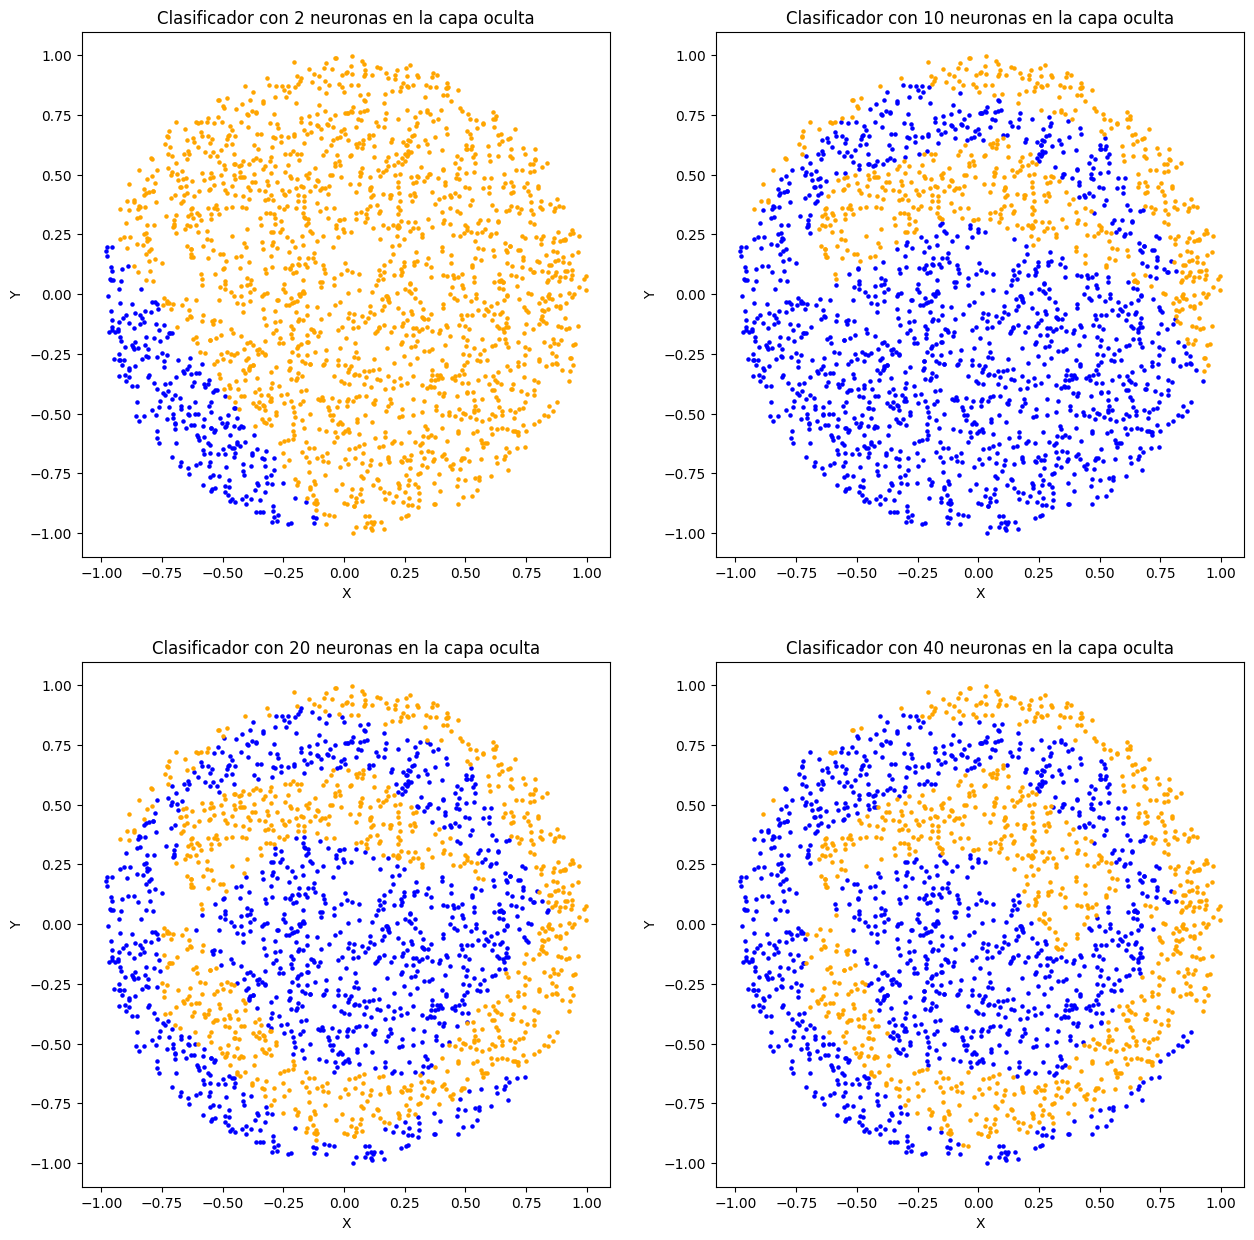

In [62]:
fig, axes = plt.subplots(2,2, figsize = (15,15))
axes = axes.flatten()

for i, classifier in enumerate(bestClassifiers):
    
    prediction = classifier.predict(XTest)

    testArray = np.array(XTest)
    
    class0 = testArray[prediction == 0] 
    class1 = testArray[prediction == 1] 

    axes[i].scatter(class0[:,0], class0[:,1], color="blue", s = 5)
    axes[i].scatter(class1[:,0], class1[:,1], color="orange", s = 5)

    axes[i].set(xlabel = 'X', ylabel = 'Y', title = f'Clasificador con {hiddenNeuronCount[i]} neuronas en la capa oculta')

### Comentarios sobre los resultados
Primero de todo, comentaremos sobre los resultados que podemos observar directamente en las gráficas. Claramente podemos notar que a medida que aumentamos el número de neuronas presentes en la capa oculta, las predicciones que hacen los clasificadores sobre el conjunto de test son mucho mejores. Al pasar de 10 a 20 neuronas, el cambio es notorio ya que toda la estructura de la espiral aparece mucho mejor definida. El paso de 20 a 40 neuronas únicamente mejora la sección de la espiral cercana al origen de coordenadas, pero sigue manteniendo la estructura principal del conjunto de datos. Como vimos en la teoría, a medida que aumentamos el número de número de neuronas ocultas, tenemos más capacidad y más flexibilidd para representar cualquier función: en otras palabras, dividir de mejor manera las dos clases que definen el problema de las espirales.

Otra cosa que podemos mencionar, es la suavidad con las que las dos clases se dividen. Mientras que en árboles teníamos dividiones escalonadas y rectas (debido a la naturaleza de las preguntas que los árboles hacían sobre los atributos de los datos), las redes pueden generar curvas de división suaves debido a la naturaleza de las transformaciones no lineales que pueden describir.

También vale mencionar que los resultados obtenidos los conseguimos luego de correr unas cuatro veces los clasificadores, entrenándolos desde 0. En los intentos anteriores los resultados para 20 y 40 neuronas no fueron tan buenos como en las gráficas que mostramos, aunque seguían describiendo de una muy buena manera la estructura principal de la espiral. Para 2 y 10 neuronas los resultados siempre fueron malos.

Por último, tenemos un comentario relacionado con el Trabajo Práctico anterior. Si miramos el ejercicio de clasificación de espirales que hicimos con árboles, podemos notar que los árboles hicieron un trabajo decente con 600 datos de entrenamiento, pero que tampoco fue excelente. Es por ésto que no nos sorprendío mucho que las redes no realicen una clasificación extremadamente mejor que los árboles. Además, tenemos que considerar que una proporción de los datos del conjunto de test se utilizan como validación, asi que tenemos menos datos para aprender.

# Problema 2 - Mínimos locales

Baje el dataset dos-elipses de la descargas. Realice varios entrenamientos con los siguientes parámetros: 6 neuronas en la capa intermedia, 500 patrones en el training set, de los cuales 400 se usan para entrenar y 100 para validar el modelo (sacados del .data), 2000 patrones en el test set (del .test), 300 evaluaciones del entrenamiento, cada una de 50 épocas. 

Pruebe distintos valores de momentum y learning-rate (valores usuales son 0, 0.5, 0.9 para el momentum y 0.1, 0.01, 0.001 para el learning-rate, pero no hay por qué limitarse a esos valores), para tratar de encontrar el mejor mínimo posible de la función error. El valor que vamos a usar es el promedio de 10 entrenamientos iguales, dado que los entrenamientos incorporan el azar. Como guía, con los parámetros dados, hay soluciones entre 5% y 6% de error en test, y tal vez mejores. Confeccione una tabla con los valores usados para los parámetros y el resultado en test obtenido (la media de las 10 ejecuciones). Haga una gráfica de error de train, validación y test en función del número de épocas para los valores seleccionados (los mejores valores de eta y alfa). 

## Resolución
Comencemos por cargar los datasets de entrenamiento y test como dataframes,

In [25]:
dataPath = "dos_elipses.data"
testPath = "dos_elipses.test"

dosElipsesData = dataFrameFromFile(dataPath, hasTrailingCommas = True)
dosElipsesTest = dataFrameFromFile(testPath, hasTrailingCommas = True)

/tmp/ipykernel_86002/1737296988.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: float(str(x).strip(',')))
/tmp/ipykernel_86002/1737296988.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: float(str(x).strip(',')))


Definamos ahora los parametros del problema

In [26]:
hiddenNeuronCount = 6

trainSize      = 400
validationSize = 100
totalTrainSize = trainSize + validationSize

testSize       = 2000
trainingEvals  = 300
epochsPerEval  = 50

momentums = [0, 0.5, 0.9]
learningRates = [0.1, 0.01, 0.001]

# Realizaremos 10 entrenamientos en total para tomar la media de todos ellos
trainingsCount = 10

Como se trata de un problema de clasificación, generemos entonces los *MLPClassifiers*,

In [27]:
classifiers = []

# Para cada valor de momentum
for momentum in momentums:

    # Creamos una lista de clasificadores con ese momentum
    classifiersPerMomentum = []

    # Y para cada valor de learning rate
    for learningRate in learningRates:

        # Agregamos el clasificador con ese learning rate y momentum a la lista de clasificadores con momentum
        classifiersPerMomentum.append(
            MLPClassifier(
                hidden_layer_sizes=(hiddenNeuronCount,),
                activation = 'logistic',
                solver = 'sgd',
                alpha = 0.0,
                batch_size = 1,
                learning_rate = 'constant',
                learning_rate_init = learningRate,
                momentum = momentum,
                nesterovs_momentum = False,
                tol = 0.0,
                warm_start = True,
                max_iter = epochsPerEval
            )
        )

    classifiers.append(classifiersPerMomentum)

Tomemos ahora las muestras pedidas del conjunto de entrenamiento y de testing,

In [28]:
# Primero generamos la muestra con `totalTrainSize` datos
dataSample = dosElipsesData.sample(n = totalTrainSize, random_state = 420)

# De los cuales nos quedamos `trainSize` datos para entrenamiento y `totalTrainSize` - `trainSize` para validacion.
trainSet, validationSet = skl.model_selection.train_test_split(dataSample, train_size = trainSize)

# Y tomamos la muestra de testeo,
testSet = dosElipsesTest.sample(n = testSize, random_state = 420)

Y entrenamos los clasificadores

In [29]:
# Primero separamos 
XTrain,      YTrain      = divideDataFrame(trainSet)
XValidation, YValidation = divideDataFrame(validationSet)
XTest,       YTest       = divideDataFrame(testSet) 

train_errors = []
val_errors   = []
test_errors  = []
best_classifier_test_errors = []


'''
Esta funcion quedo media complicada porque lo que tenemos es

trainErrorsAcum = [  [error1, error2, ..., errorTrainingEvals],      <--- entrenamiento 1
                     [error1, error2, ..., errorTrainingEvals]       <--- entrenamiento 2
                     [error1, error2, ..., errorTrainingEvals]       <--- entrenamiento 3
                                       .
                                       .
                                       .
                     [error1, error2, ..., errorTrainingEvals] ]     <--- entrenamiento trainingCount

Y nosotros queremos el avg de la columna error1, el de la error2, etc. No podemos hacer mean() de cada fila.

'''

# Para cada lista de clasificadores con cierto momentum
# (classifiers es una lista tal que su i-esimo elemento es una lista de clasificadores definidos con momentums[i]
# y variando el learningRate)
for classifiersPerMomentum in classifiers:

    # Inicializamos sus listas de error
    train_errors_per_momentum = []
    val_errors_per_momentum   = []
    test_errors_per_momentum  = []

    best_classifier_error_per_momentum = []
    
    # Y para cada clasificador dentro de la lista
    for classifier in classifiersPerMomentum:

        print("Comenzando con un nuevo clasificador.")

        # Obtenemos sus errores de train, validacion, y test por evaluacion.
        # {}_errors_per_eval es la lista de errores de {}, donde el i-esimo elemento se  corresponde con
        # el error de {} tras la evaluacion (i.e. realizacion de `epochsPerEval` epocas) i-esima.

        # Aca vamos guardando los errores de cada uno de los `trainingsCount` entrenamientos
        train_errors_acum = []
        val_errors_acum = []
        test_errors_acum = []
        best_classifier_error_acum = []

        # Y estas van a ser las listas con los valores promedios de error para cada entrenamiento, diferenciado tambien por
        # evaluacion. 
        # i.e. van a tener 300 elementos cada una, donde cada uno de los elementos es el promedio de 10 entrenamientos.
        train_error_avg_list = []
        val_error_avg_list   = []
        test_error_avg_list  = []

        # Realizamos `trainingsCount` entrenamientos y tomamos el promedio
        # {}_errors_acum es una lista donde el i-esimo elemento es una lista tal que su j-esimo elemento
        # es el error de {} tras la evaluacion j-esima del entrenamiento.
        for train in range(trainingsCount):
            print("Comenzando con un nuevo entrenamiento")
            _, train_errors_per_eval, val_errors_per_eval, test_errors_per_eval, best_classifier_test_error = netTrain(
                classifier, trainingEvals, XTrain, YTrain, XValidation, YValidation, XTest, YTest)
    
            train_errors_acum.append(train_errors_per_eval)
            val_errors_acum.append(val_errors_per_eval)    
            test_errors_acum.append(test_errors_per_eval)    
            best_classifier_error_acum.append(best_classifier_test_error)

        # Ahora, reducimos las listas de listas a una sola lista de errores promedio
        # Para cada una de las `trainingEvals` evaluaciones de entrenamiento
        for i in range(trainingEvals): # i.e. for i in range(300)

            train_error_sum = 0
            val_error_sum   = 0
            test_error_sum  = 0
            
            # Y para cada uno de los `trainingsCount` entrenamientos
            for trainNumber in range(trainingsCount):

                # Acumulamos el valor de la i-esima evaluacion en cada entrenamiento
                train_error_sum = train_error_sum + train_errors_acum[trainNumber][i] 
                val_error_sum   = val_error_sum   + val_errors_acum[trainNumber][i]
                test_error_sum  = test_error_sum  + test_errors_acum[trainNumber][i]

            # Ahora tenemos el acumulado para la trainingEval i-esima en las variables {}_error_avg
            # Queda dividir por la cantidad `trainingsCount` y guardarlas
            train_error_avg_list.append(train_error_sum / trainingsCount)
            val_error_avg_list.append(val_error_sum / trainingsCount)
            test_error_avg_list.append(test_error_sum / trainingsCount)
            
        # Y ahora agregamos estas listas promediadas a sus respectivas listas `per_momentum`
        train_errors_per_momentum.append(train_error_avg_list)
        val_errors_per_momentum.append(val_error_avg_list)
        test_errors_per_momentum.append(test_error_avg_list)
        best_classifier_error_per_momentum.append(np.mean(best_classifier_error_acum))

    # Por ultimo, agregamos cada una de estas listas `per_momentum` a la lista general de errores,
    # que contiene los errores de cada combinacion de momentum y learningRate posible
    train_errors.append(train_errors_per_momentum)
    val_errors.append(val_errors_per_momentum)
    test_errors.append(test_errors_per_momentum)
    best_classifier_test_errors.append(best_classifier_error_per_momentum)

Comenzando con un nuevo clasificador.
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo clasificador.
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo clasificador.
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando con un nuevo entrenamiento
Comenzando c

Veamos ahora las gráficas de error en función de las evaluaciones de entrenamiento,

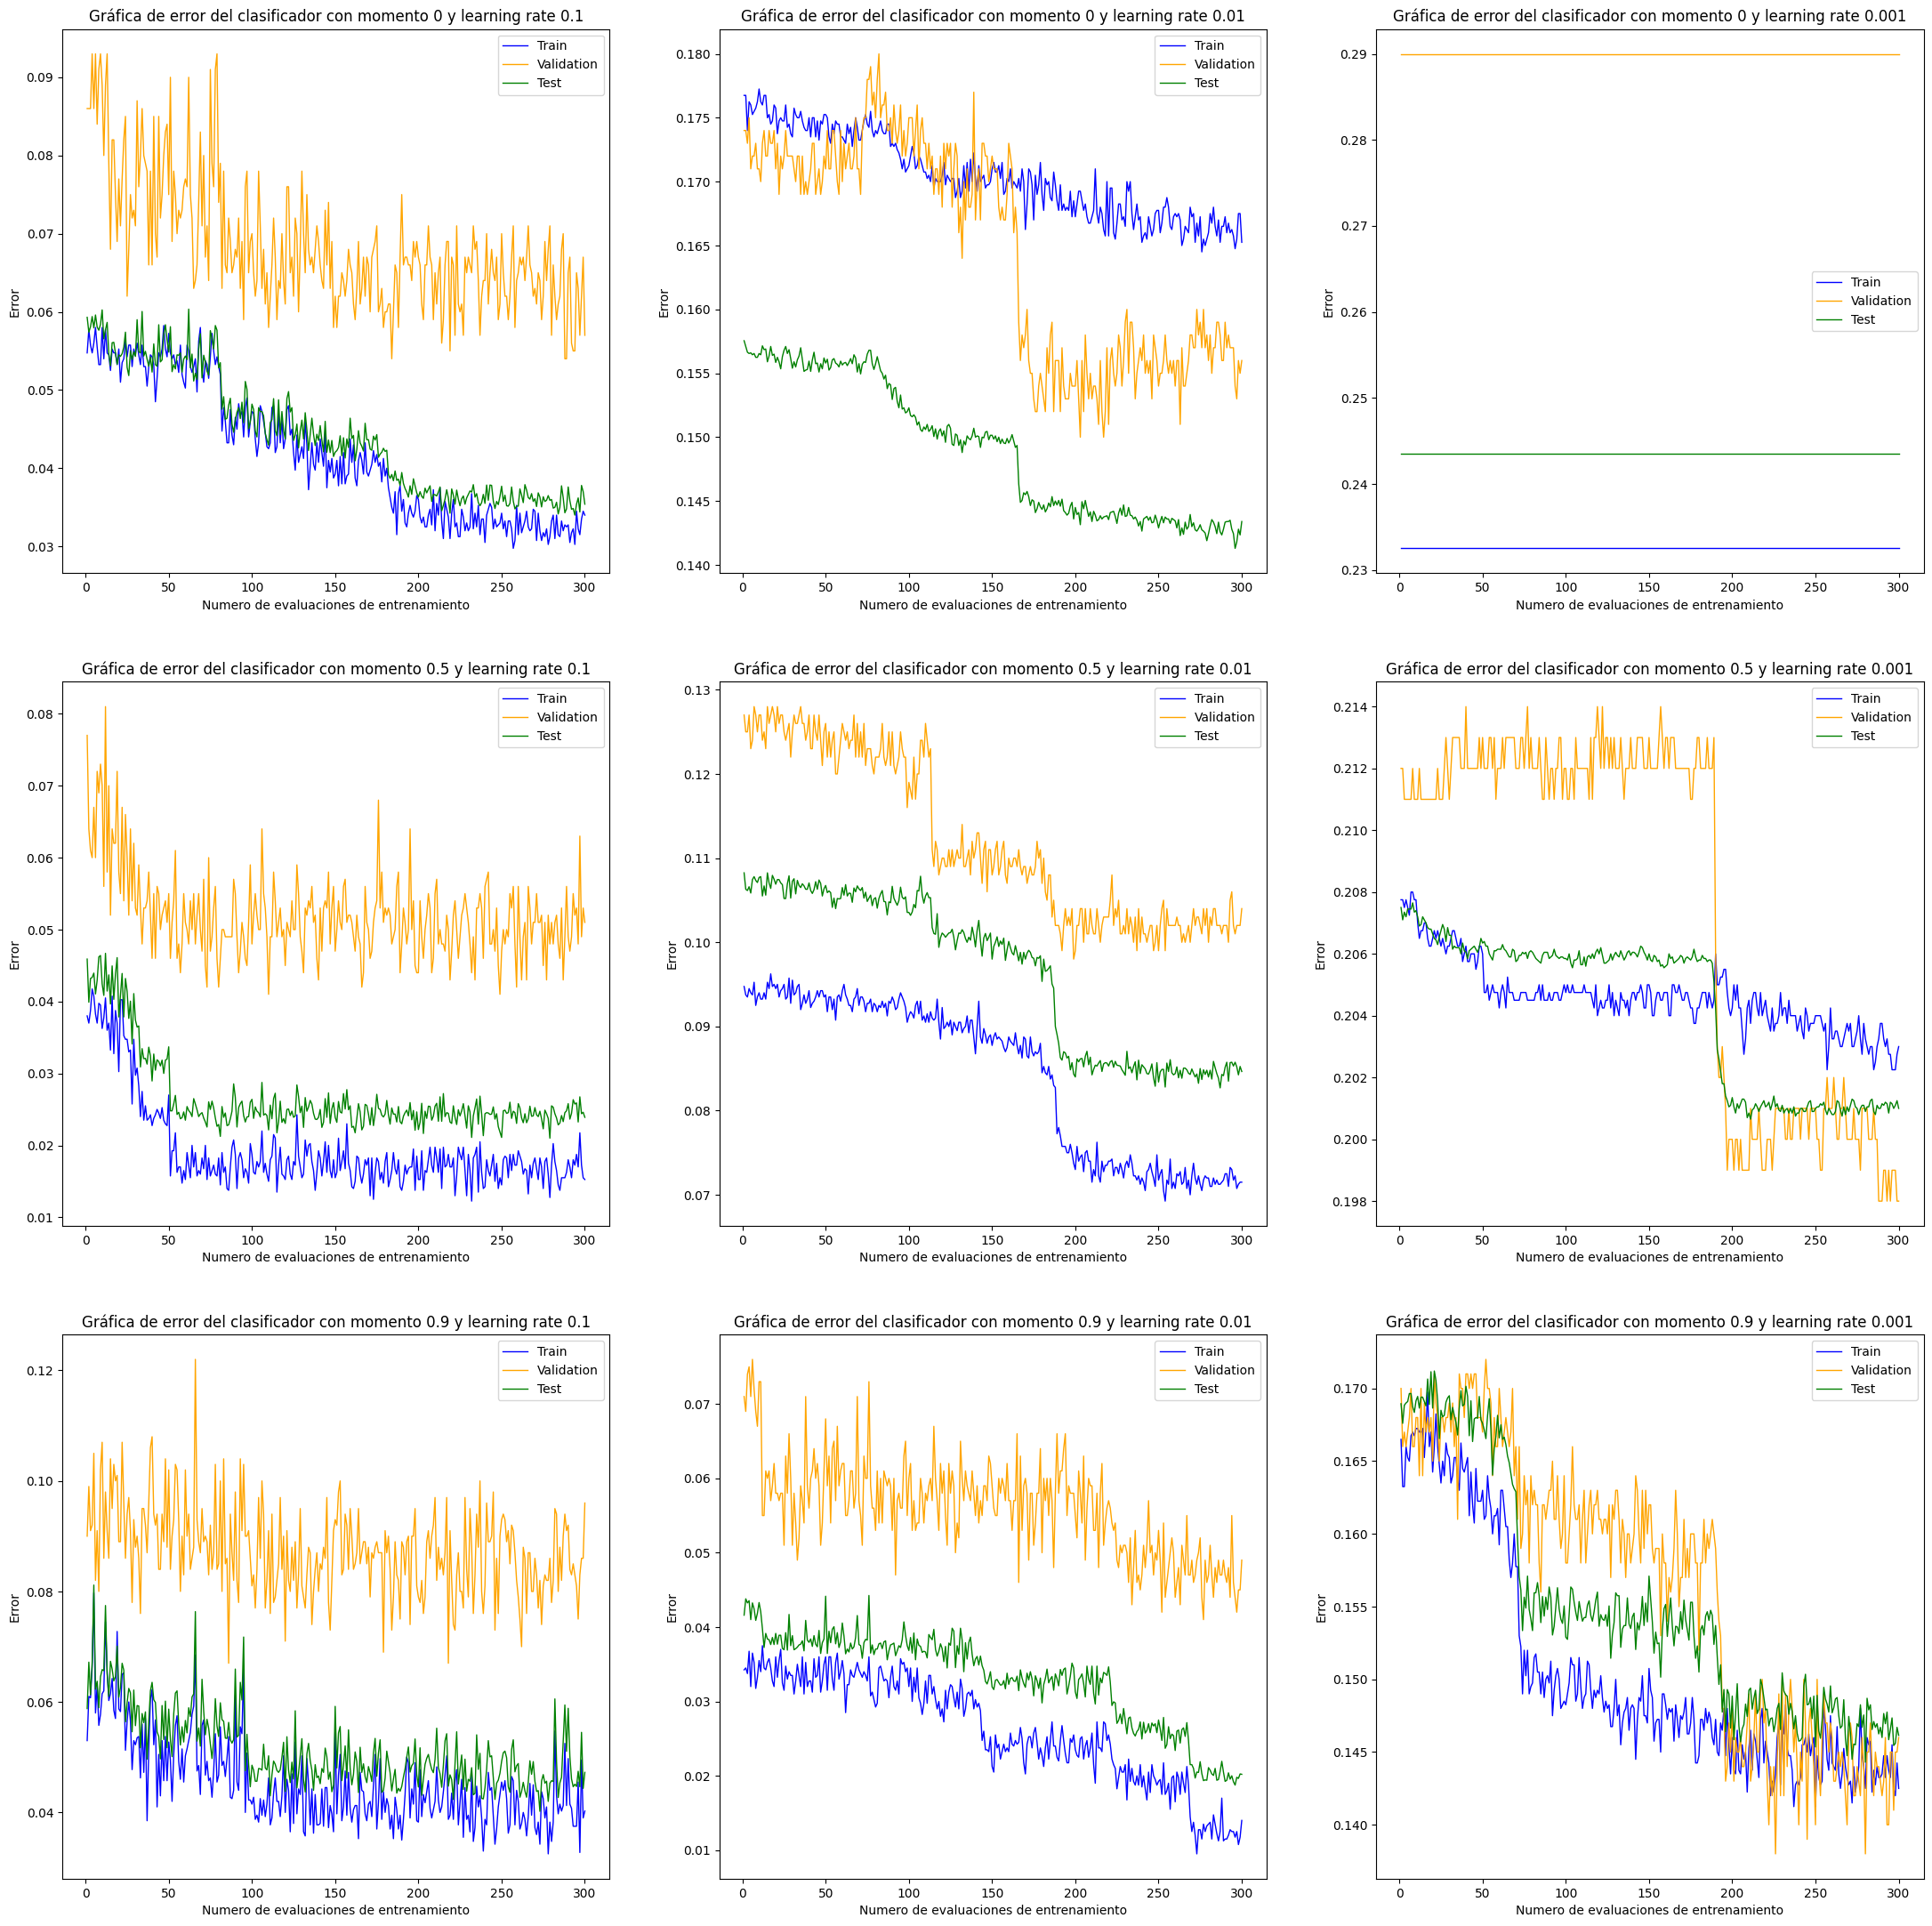

In [30]:
fig, axes = plt.subplots(3,3, figsize = (27,27))
# axes = axes.flatten()

# Aplanamos los errores para que sea mas facil
# train_errors = np.array(train_errors).flatten().tolist()
# val_errors = np.array(val_errors).flatten().tolist()
# test_errors = np.array(test_errors).flatten().tolist()



# Para cada combinacion posible de momento y learningRate
for lr in range(len(learningRates)):

    for mm in range(len(momentums)):

        # idx = lr + mm
        
        XValues = [i for i in range(1, trainingEvals + 1)]
        
        axes[mm][lr].plot(XValues, train_errors[mm][lr], color="blue",   linewidth=1, label='Train')
        axes[mm][lr].plot(XValues, val_errors[mm][lr],   color="orange", linewidth=1, label='Validation')
        axes[mm][lr].plot(XValues, test_errors[mm][lr],  color="green",  linewidth=1, label='Test')

        axes[mm][lr].set(xlabel = 'Numero de evaluaciones de entrenamiento',
                      ylabel = 'Error',
                      title  = f"Gráfica de error del clasificador con momento {momentums[mm]} y learning rate {learningRates[lr]}")

        axes[mm][lr].legend()

plt.savefig("ej2.png")

Veamos ahora la tabla con los valores para los parámetros escogidos y el error de test para esa combinación,

In [34]:
# Construyamos la matriz con los errores de test del mejor clasificador en terminos del validation set
best_classifier_test_errors = np.zeros((len(momentums), len(learningRates)))

for mm in range(len(momentums)):
    for lr in range(len(learningRates)):
        # Find the epoch with minimum validation error
        k = np.argmin(val_errors[mm][lr])
        # Store the corresponding test error
        best_classifier_test_errors[mm][lr] = test_errors[mm][lr][k]

results_df = pd.DataFrame(
    best_classifier_test_errors,
    index=[f"momentum = {m:.1f}" for m in momentums],
    columns=[f"learningRate = {lr:.3f}" for lr in learningRates]
)

def colorear_optimo(val):
    optimo = results_df.min().min() 
    return ['background-color: yellow' if v == optimo else '' for v in val]

styled_df = results_df.style.apply(colorear_optimo).format("{:.6f}")
styled_df

## Comentarios

En los gráficos construídos podemos observar que los resultados del entrenamiento son prácticamente los que esperabamos. Por un lado, si leemos los gráficos de izquierda a derecha es claro que conforme disminuímos el *learning rate* las curvas tienden a ser menos oscilantes. Es decír, cuando el aprendizaje (o la corrección de los pesos) se realiza de forma mas suave, las curvas de error responden con menos variación entre cada época. El caso mas extremo es el de la combinación con $momentum = 0$ y $learningRate = 0.001$, que con una tasa de aprendizaje muy pequeña y sin un momento que le permita escapar de los mínimos locales rápidamente se queda estancado en un mismo punto y sus errores no varían, pues ya no encuentra correcciones para realizar. 

Por otro lado, si observamos las gráficas de arriba hacia abajo, también es notorio que conforme aumenta el valor de momento utilizado las curvas se vuelven mucho mas oscilantes. Esto podría ser a causa de que, al tener un valor alto de momento, si en el entrenamiento el modelo comienza a corregirse hacia una dirección que no resulta ser la correcta, esto producira que el error aumente durante varias epocas de forma considerable hasta poder lograr moverse en la dirección contraria. Y nuevamente, cuando comience a moverse en otra dirección, al entrenamiento le costará múltiples iteraciones corregir su camino cuando eventualmente este deje de ser el correcto. 

Como observamos en la tabla construída, el mejor resultado lo obtenemos para la combinación con máximo momento y $learningRate = 0.01$. Esta combinación obtuvo, para su mejor valor de error de testeo, un porcentaje menor al 2%.

Un caso que no logramos explicar fue el de la combinación de $momentum = 0$ y $learningRate = 0.01$. En su gráfica podemos observar que el error de entrenamiento se encuentra por encima de las otras dos curvas de error, y particularmente por encima de la curva de test. Este comportamiento no se replicó en todos los entrenamientos: para algunas semillas este problema sucedía en la mayoría de las combinaciones, y para otras no sucedía en ninguna. Optamos por mostrar este entrenamiento en el que solo esta combinación muestra este fenomeno para ilustrar la situación. En un momento consideramos que podría ser a causa del bajo valor de momento y tasa de aprendizaje, pero como mencionamos también se replico este comportamiento en otras combinaciones dependiendo del entrenamiento, por lo que no nos quedó claro que ese sea el motivo. 

# Problema 3 - Regularización

Baje el dataset Ikeda (en todos los problemas de regresión la última columna del dataset es la variable a precedir). Realice varios entrenamientos usando el 95% del archivo .data para entrenar, y el resto para validar. Realice otros entrenamientos cambiando la relación a 75%-25%, y a 50%-50%. En cada caso seleccione un resultado que considere adecuado, y genere gráficas del mse en train, validación y test. Comente sobre los resultados. 
Los otros parámetros para el entrenamiento son: learning rate 0.01, momentum 0.9, 2000 datos para testear, 400 evaluaciones del entrenamiento, cada una de 50 épocas, 30 neuronas en la capa oculta.

## Resolución

In [7]:
@ignore_warnings(category=ConvergenceWarning)
def netTrain(net, evalsCount, trainSet, validationSet, errorFunction, testSet = None):

    XTrain, YTrain = divideDataFrame(trainSet)
    XVal, YVal = divideDataFrame(validationSet)
    
    XTest, YTest = divideDataFrame(testSet) if testSet is not None else (None, None)

    trainErrors      = []
    validationErrors = []
    testErrors       = [] if testSet is not None else None 
    bestValidationError = float('inf')
    bestNet = net
    
    for eval in range(evalsCount):

        # Entrenamos la red
        net.fit(XTrain, YTrain)
        
        # Error de entrenamiento
        YPredictTrain = net.predict(XTrain)
        trainErrors.append(errorFunction(YTrain, YPredictTrain))
        
        # Error de validacion
        YPredictValidation = net.predict(XVal)
        currentValidationError = errorFunction(YVal, YPredictValidation)
        validationErrors.append(currentValidationError)

        if (testSet is not None):
            YPredictTest = net.predict(XTest)
            testErrors.append(errorFunction(YTest, YPredictTest))

        # Nos quedamos con la red con mejor error de validacion
        if bestValidationError > currentValidationError:
            bestValidationError = currentValidationError
            bestNet = deepcopy(net)
          
    return bestNet, trainErrors, validationErrors, testErrors

Definimos los valores predeterminados

In [8]:
validationProportions = [0.05, 0.25, 0.50]

learningRate = 0.01
momentum = 0.9

hiddenNeurons = 30

testSize = 2000

trainingEvals = 400
epochsPerEval = 50

In [159]:
# Cargo los datasets que voy a utilizar
ikedaData = dataFrameFromFile("ikeda.data")
ikedaTest = dataFrameFromFile("ikeda.test")

_, testSet = skl.model_selection.train_test_split(ikedaTest, test_size = testSize) 

Primero preparo todos los conjuntos que necesite para realizar los entrenamientos con las distintas proporciones del conjunto de validación

In [160]:
# Los conjuntos de entrenamiento y validacion iran variando, mientras que el de test se mantiene igual
trainAndValidation = []
regressors = []

for validationProportion in validationProportions:

    trainSet, validationSet = skl.model_selection.train_test_split(ikedaData, test_size = validationProportion)
    trainAndValidation.append((trainSet,validationSet))

    # Necesito un regresor distinto para cada una de las proporciones
    regressors.append(MLPRegressor(hidden_layer_sizes=(hiddenNeurons,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1,
                        learning_rate='constant', learning_rate_init=learningRate,momentum=momentum,nesterovs_momentum=False,
                        tol=0.0,warm_start=True,max_iter=epochsPerEval))


Ahora entreno en celdas separadas cada uno de los regresores para poder correrlos independientemente

In [161]:
trainingInformation = [() for _  in range(3)] # Arreglo que iremos cargando con los distintos entrenamientos

In [162]:
trainSet, validationSet = trainAndValidation[0]
trainingInformation[0] = netTrain(regressors[0], trainingEvals, trainSet, validationSet, mean_squared_error, testSet = testSet)

In [163]:
trainSet, validationSet = trainAndValidation[1]
trainingInformation[1] = netTrain(regressors[1], trainingEvals, trainSet, validationSet, mean_squared_error, testSet = testSet)

In [164]:
trainSet, validationSet = trainAndValidation[2]
trainingInformation[2] = netTrain(regressors[2], trainingEvals, trainSet, validationSet, mean_squared_error, testSet = testSet)

Ahora, con los datos de los tres regresores que seleccionamos, realizamos graáficas del Mean Squeared Error para los conjuntos de test, validación y entrenamiento.

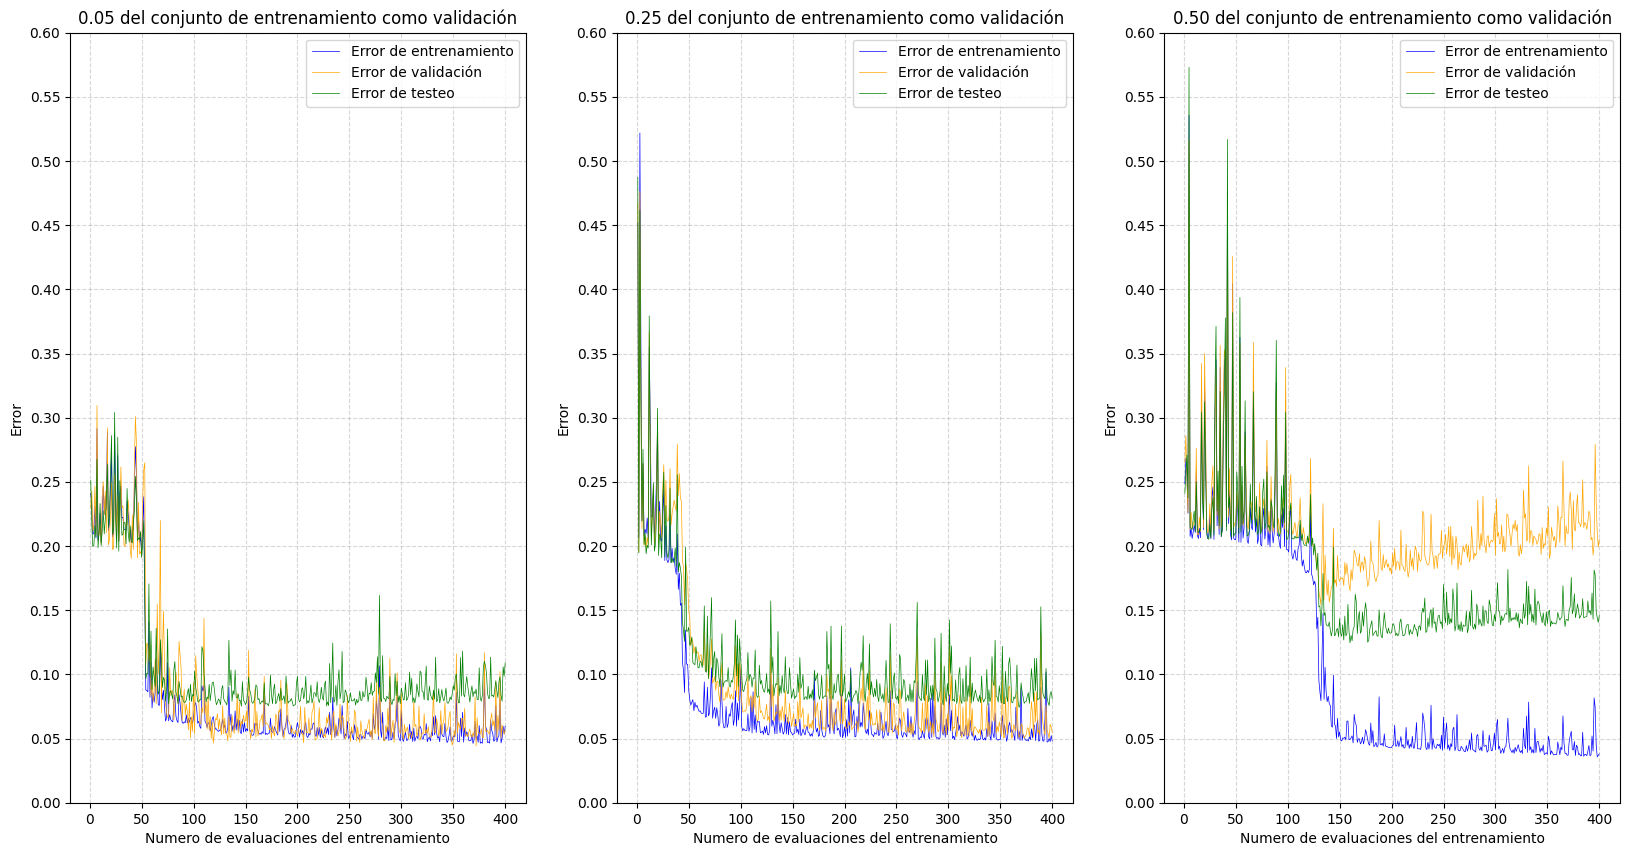

In [165]:
fig, axes = plt.subplots(1,3, figsize = (20,10))
axes = axes.flatten()

for i,information in enumerate(trainingInformation):

    _, trainErrors, validationErrors, testErrors = information
    
    XValues = [i for i in range(1,trainingEvals + 1)]
    
    axes[i].plot(XValues, trainErrors, color="blue", label = "Error de entrenamiento", linewidth = 0.5)
    axes[i].plot(XValues, validationErrors, color="orange", label = "Error de validación", linewidth = 0.5)
    axes[i].plot(XValues, testErrors, color="green", label = "Error de testeo", linewidth = 0.5)

    axes[i].set(xlabel = 'Numero de evaluaciones del entrenamiento', ylabel = 'Error', title = f'{validationProportions[i]:.2f} del conjunto de entrenamiento como validación')
    axes[i].legend()

     # Y setteamos los valores del eje Y para que matcheen con nuestros resultados
    axes[i].set_yticks(np.arange(0,0.65, 0.05))
    axes[i].set_ylim(bottom=0)
    axes[i].grid(True, which="both", linestyle='--', alpha=0.5)

Comparemos ahora los resultados en los tres tipos de errores para el mejor clasificador (en términos de su resultado sobre el conjunto de validación) de cada proporcion.

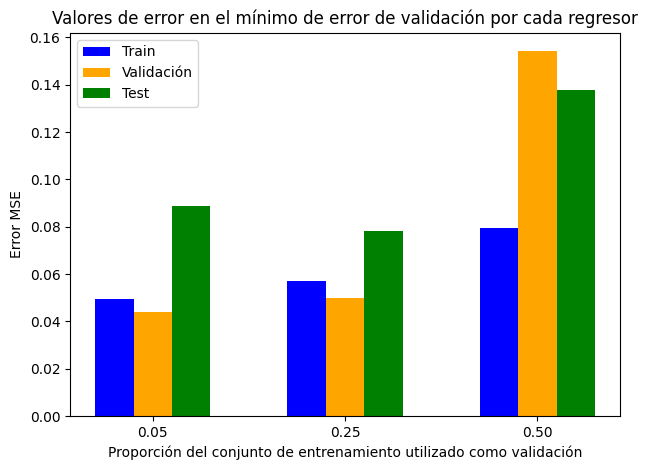

In [166]:
best_train_errors = []
best_val_errors = []
best_test_errors = []

# Para cada clasificador
for i in range(len(trainingInformation)):
    val_errors = trainingInformation[i][2]
    min_idx = val_errors.index(min(val_errors))  # Epoch con menor error de validación

    # Guardamos los errores correspondientes a ese epoch
    best_train_errors.append(trainingInformation[i][1][min_idx])
    best_val_errors.append(trainingInformation[i][2][min_idx])
    best_test_errors.append(trainingInformation[i][3][min_idx])

# Ahora graficamos los 3 sets de errores
regressors_names = [f'{validationProportions[i]:.2f}' for i in range(len(trainingInformation))]
error_types = ['Train', 'Validación', 'Test']
colors = ['blue', 'orange', 'green']
bar_width = 0.2
x = np.arange(len(regressors_names))

fig, ax = plt.subplots()

ax.bar(x - bar_width, best_train_errors, width=bar_width, label='Train', color=colors[0])
ax.bar(x, best_val_errors, width=bar_width, label='Validación', color=colors[1])
ax.bar(x + bar_width, best_test_errors, width=bar_width, label='Test', color=colors[2])

# Estética
ax.set_xlabel('Proporción del conjunto de entrenamiento utilizado como validación')
ax.set_ylabel('Error MSE')
ax.set_title('Valores de error en el mínimo de error de validación por cada regresor')
ax.set_xticks(x)
ax.set_xticklabels(regressors_names)
ax.legend()

plt.tight_layout()
plt.show()

### Comentarios sobre los resultados
Primero realizamos gráficas de los errores de entrenamiento, test y validación, para cada uno de los clasificadores. Cada uno de ellos fue entrenado con una proporción diferente del conjunto de entrenamiento como conjunto de validación. Nos interesó también incluir una gráfica en donde se ven los distintores errores de la red entrenada (con el menor error de validación) para cada uno de los valores de proporción del conjunto de validación.

TERMINAR DE ESCRIBIR CONCLUSIONES

# Problema 4 - Regularización 
Vamos a usar regularización por penalización, el weight-decay. Hay que tener cuidado con los nombres de los parámetros en este caso. El parámetro que nosotros llamamos gamma en la teoría corresponde en MLP de sklearn al parámetro alpha, mientras que nosotros usamos alfa para el momentum en general. Para activarlo tenemos que usar,

*gamma=0.00001*

*regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma,
                    batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,
                    nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)*

En este tipo de regularización no se usa un conjunto de validación, asi que hay que modificar la función que crearon para evaluar el entrenamiento de las redes, para que en lugar del error sobre el conjunto de validación, nos devuelva la suma de los valores absolutos o de los valores al cuadrado de todos los pesos de la red en la epoca correspondiente, y todo el resto igual que antes.

Una vez implementado, aplíquelo al dataset Sunspots (ssp). Busque el valor de gamma adecuado para conseguir un equilibrio entre evitar el sobreajuste y hacer el modelo demasiado rígido (el valor de gamma se debe variar en varios órdenes de magnitud, por ejemplo empezar en 10^-6 e ir hasta 10^0 (1) de a un orden cada vez). En este caso todos los registros del archivo .data se deben usar para el entrenamiento, ya que la regularización se realiza con la penalización a los pesos grandes. 
Los otros parámetros se pueden tomar: learning rate 0.05, momentum 0.3, 4000 evaluaciones del entrenamiento, cada una de 20 épocas, 6 neuronas en la capa intermedia.

Entregue curvas de los tres errores (entrenamiento y test en una figura, penalización en otra figura) para el valor de gamma elegido, y para algún otro valor en que haya observado sobreajuste. Comente los resultados.

## Resolución
Comencemos por redefinir la funcion de entrenamiento para este ejercicio,

In [6]:
@ignore_warnings(category=ConvergenceWarning)
def netTrain4(net, evalsCount, X_train, y_train, X_test,  y_test):
    """
    Función que entrena una red ya definida previamente "evalsCount" veces,
    cada vez entrenando un número de épocas elegido al crear la red y midiendo
    el error en train, validación y test al terminar ese paso de entrenamiento.
    Guarda y devuelve la red en el paso de evaluación que da el mínimo error de
    validación.

    Argumentos:
      net: red neuronal predefinida
      evalsCount (int): las veces que evalua
      X_{}: los conjuntos de valores de entrada de train, y test
      y_{}: los conjuntos de valores de salida o clase

    Salidas:
      net: la red entrenada en el mínimo de validación
      error_{}: los errores de: train y test medidos en cada evaluación
      squared_weights: la suma de los cuadrados de los pesos en cada evaluacion
    """
    
    error_train = []
    error_test = []
    pesos_por_epoca = []
    
    for eval in range(evalsCount):
        net.fit(X_train, y_train)

        # Error de entrenamiento
        y_pred_train = net.predict(X_train)
        error_train.append(mean_squared_error(y_train, y_pred_train))
      
        # error de test, calcularlo con MSE?
        # ir quedandose con el mejor y devolverlo?
        y_pred_test = net.predict(X_test)
        error_test.append(mean_squared_error(y_test, y_pred_test))

        # Suma de los errores cuadrados
        pesos_cuadrados = 0
        for pesos_por_capa in net.coefs_:
            pesos_cuadrados += np.sum(pesos_por_capa ** 2)

        pesos_por_epoca.append(pesos_cuadrados)        
          
    return error_train, error_test, pesos_por_epoca

Ahora definamos los parámetros de la red y creemos los regressors,

In [7]:
gammas = [10 ** i for i in range(-6, 1)]

learningRate = 0.05
momentum = 0.3
trainingEvals = 4000
epochsPerEval = 20
hiddenNeuronCount = 6

In [8]:
regressors = []

# Para cada valor de gamma
for gamma in gammas:

    # Agregamos el clasificador con ese gamma y los demas parametros iguales a la lista
    regressors.append(
            MLPRegressor(
                hidden_layer_sizes=(hiddenNeuronCount,),
                activation = 'logistic',
                solver = 'sgd',
                alpha = gamma,
                batch_size = 1,
                learning_rate = 'constant',
                learning_rate_init = learningRate,
                momentum = momentum,
                nesterovs_momentum = False,
                tol = 0.0,
                warm_start = True,
                max_iter = epochsPerEval
            )
        )
    

Carguemos ahora los sets de entrenamiento y de test, y los separamos en XTrain e YTrain

In [9]:
sspData = pd.read_csv(
    'ssp.data',  
    header=None,            # No hay headers
)


sspTest = pd.read_csv(
    'ssp.test',  
    header=None,            # No hay headers
)

# Nos quedamos con las primeras 12 columnas como input y la ultima como output en ambos casos.
XTrain = sspData.iloc[:, :-1]  
YTrain = sspData.iloc[:, -1]   

XTest = sspTest.iloc[:, :-1] 
YTest = sspTest.iloc[:, -1]   

Entrenemos la red

In [10]:
train_errors = []
test_errors = []
squared_weights = []

# Para cada regresor
for regressor in regressors:
    print("Entrenando")
    
    # Entrenamos el regresor
    regressor_train_error, regressor_test_error, regressor_squared_weight = netTrain4(regressor, trainingEvals,
                                                                                      XTrain, YTrain, XTest, YTest)

    # Y nos guardamos su lista de estadisticas
    train_errors.append(regressor_train_error)
    test_errors.append(regressor_test_error)
    squared_weights.append(regressor_squared_weight)

Entrenando
Entrenando
Entrenando
Entrenando
Entrenando
Entrenando
Entrenando


Visualicemos los resultados,

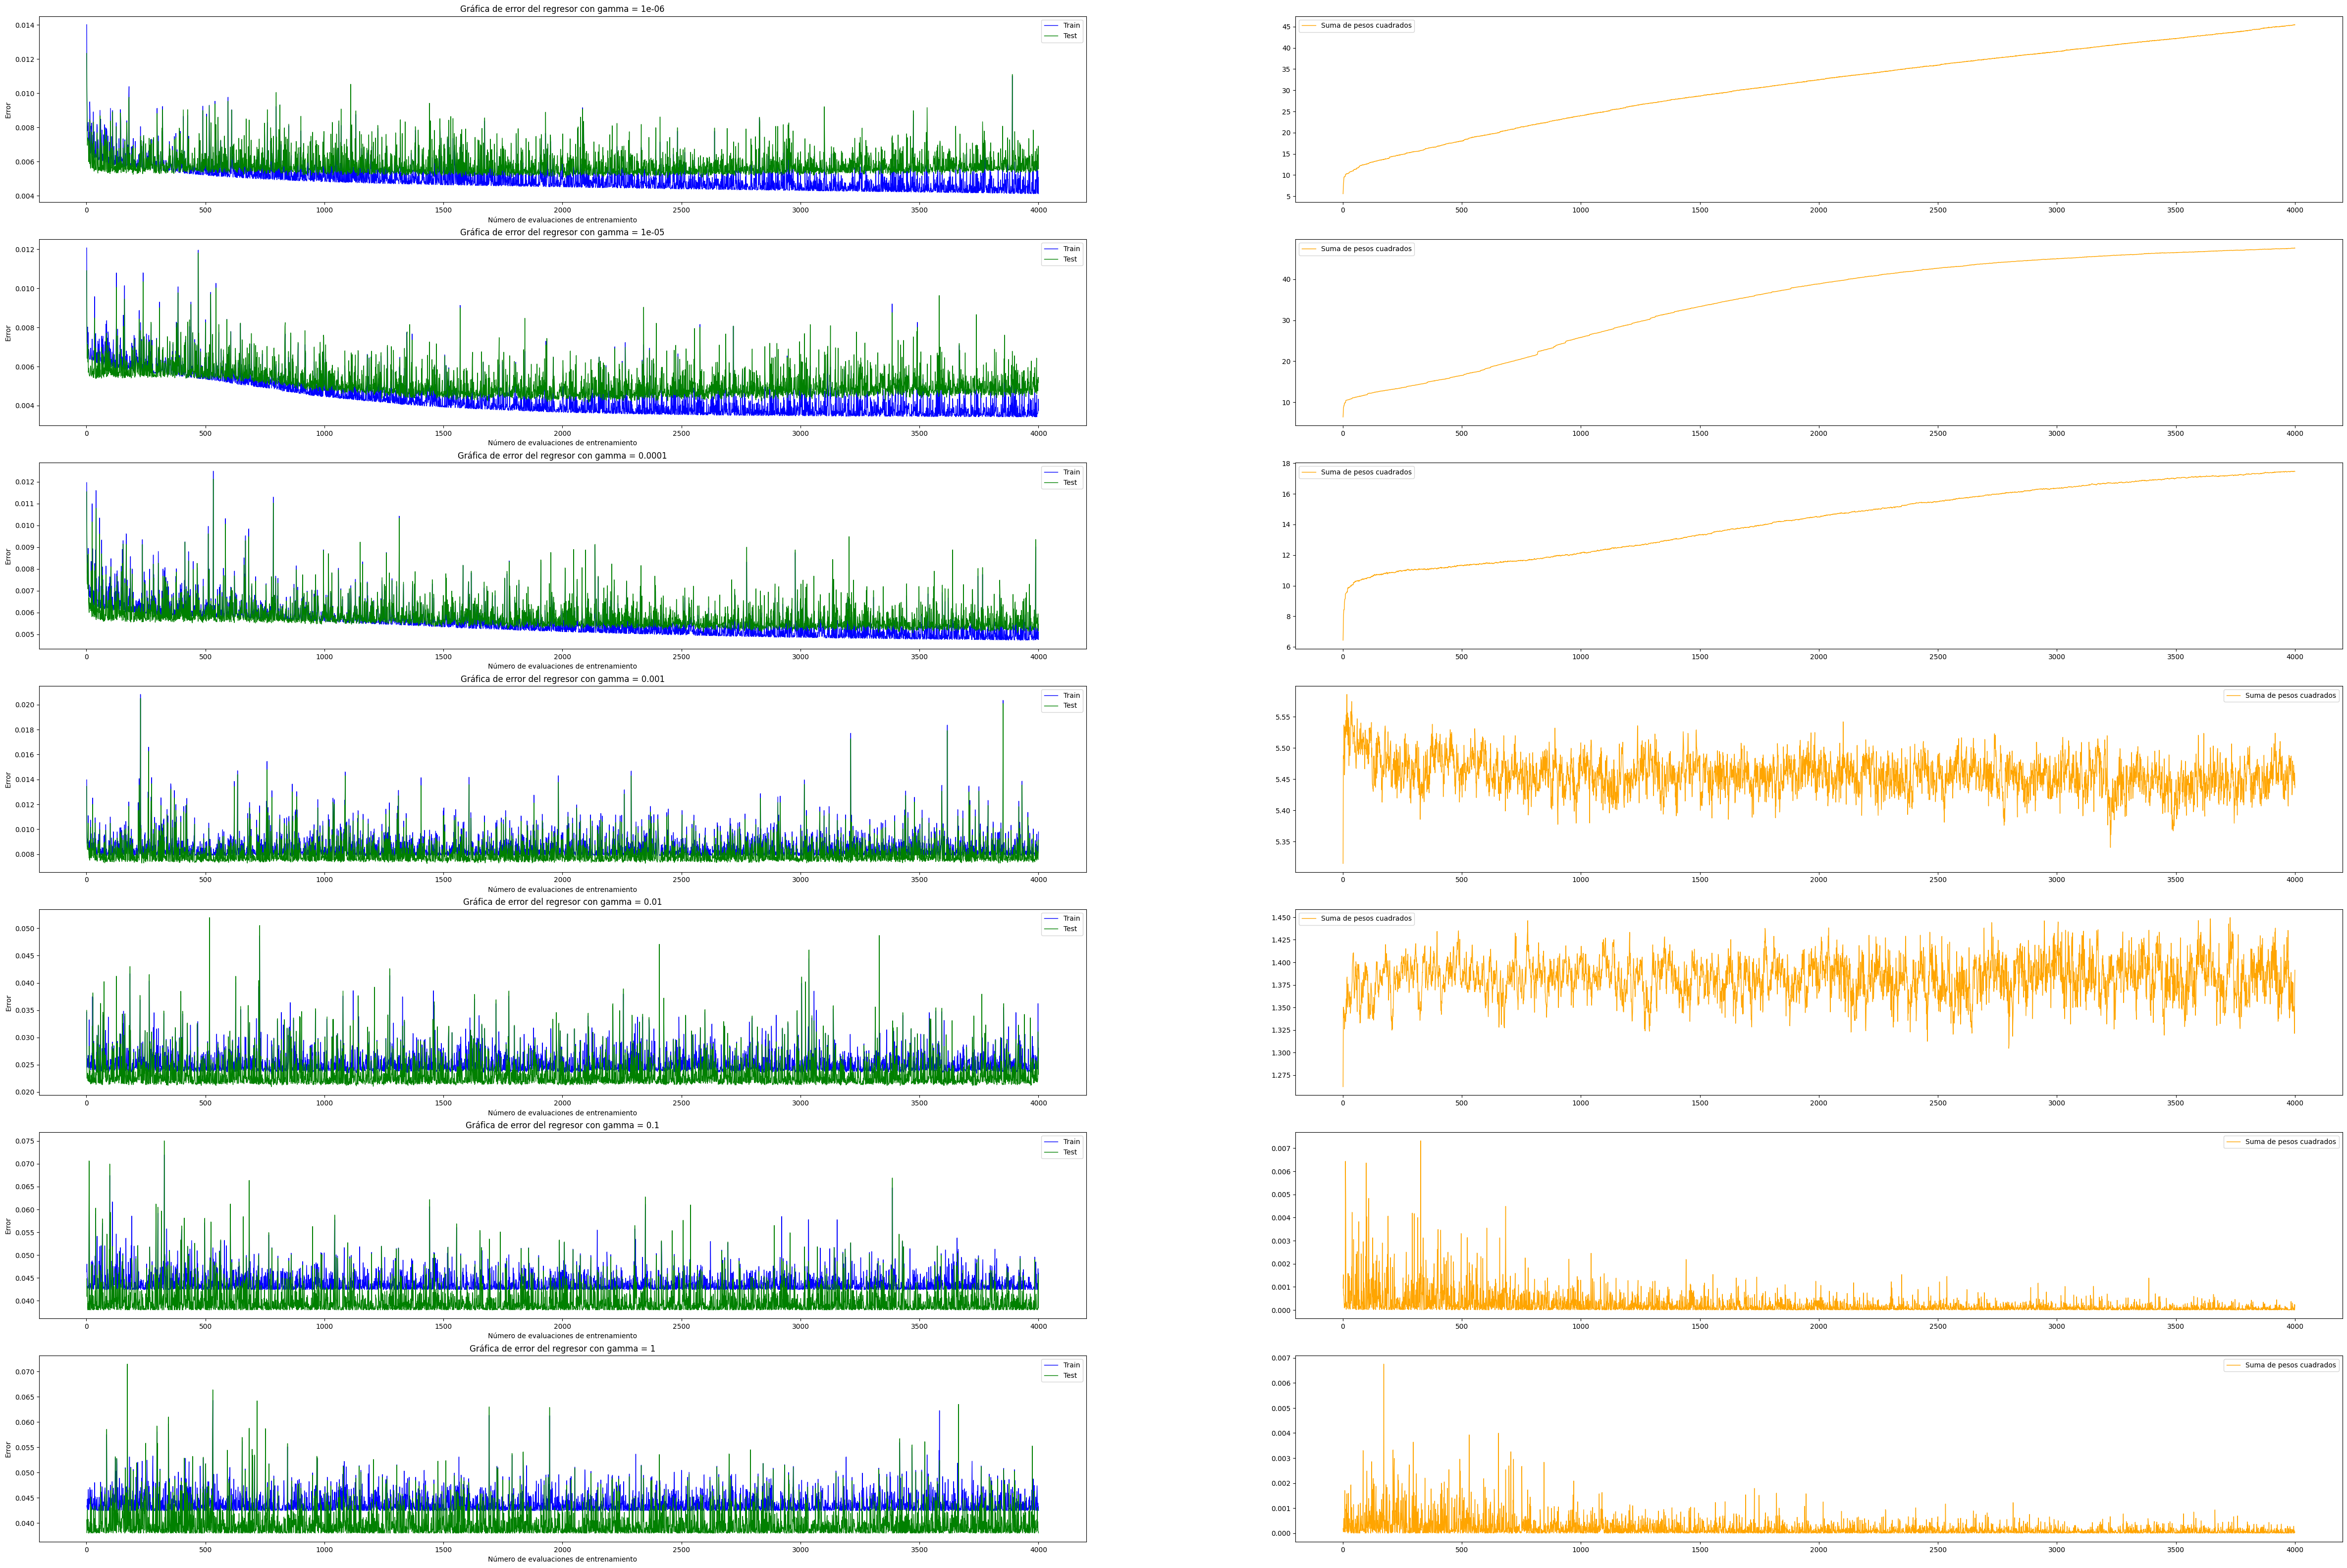

In [12]:
# Cada fila sera un clasificador, donde la primer columna son sus errores y la segunda los pesos
fig, axes = plt.subplots(len(gammas), 2, figsize = (60, 40))
# axes = axes.flatten()

for i, gamma in enumerate(gammas):

    errorPlotCol = 0
    weightSumCol = 1
    
    XValues = [i for i in range(1, trainingEvals + 1)]

    # Generamos la grafica de los valores de error
    axes[i][errorPlotCol].plot(XValues, train_errors[i], color = "blue", linewidth = 1, label = 'Train')
    axes[i][errorPlotCol].plot(XValues, test_errors[i], color = "green", linewidth = 1, label = 'Test')

    # Y al lado la de los pesos
    axes[i][weightSumCol].plot(XValues, squared_weights[i], color = "orange", linewidth = 1, label = 'Suma de pesos cuadrados')

    axes[i][errorPlotCol].set(xlabel = 'Número de evaluaciones de entrenamiento',
                              ylabel = 'Error',
                              title  = f"Gráfica de error del regresor con gamma = {gamma}")
        
    # Imprimimos las leyendas
    axes[i][errorPlotCol].legend()
    axes[i][weightSumCol].legend()

plt.savefig("ej4.png")

## Conclusiones

En las gráficas podemos observar que, como podíamos esperar, conforme aumentamos el valor de $\gamma$ la suma de los cuadrados de los pesos disminuye también. Es decir, cuanto mas valoramos en el cálculo de error al término que considera la suma de los pesos, mas se valora en el entrenamiento a los vectores de pesos con valores pequeños. 

Lo mas notorio es el desplazamiento relativo de la curva de error de entrenamiento respecto a la curva de error de test. Mientras que para valores de $\gamma$ pequeños la curva de error de entrenamiento tiende a ubicarse por debajo de la curva de error de test a medida que aumenta el número de evaluaciones de entrenamiento, este comportamiento empieza a revertirse cuando $\gamma$ crece. Conforme aumentamos el coeficiente de regularización es claro que la curva de error de entrenamiento empieza a ubicarse por encima de la curva de error de test.

La explicación de este fenómeno es que si desalentamos que el modelo aprenda valores altos para sus pesos, este tenderá a sobreajustar menos, por lo que tendrá un peor desempeño sobre el conjunto de entrenamiento y generalizará mejor, cometiendo entonces menos errores en el conjunto de test.

# Problema 5 - Dimensionalidad
Repita el punto 4 del Práctico 1, usando ahora redes con 6 unidades en la capa intermedia. Los otros parámetros hay que setearlos adecuadamente, usando como guía los casos anteriores. Genere una gráfica que incluya los resultados de redes y árboles. 

## Resolución

Primero, definamos las funciones que nos serán de utilidad para el ejercicio. Muchas de éstas las reutilizamos del TP anterior.

In [10]:
# Definimos una funcion que dados los parametros y la lista de valores de d (dimensionalidad) genere la lista de training sets
def generateTrainingSetsD(setCount, generator, C, n, dims):

    # Inicializamos la lista de conjuntos de entrenamiento
    trainingSets = [[] for _ in range(len(dims))]
    
    # Para cada dimension
    for i, d in enumerate(dims):

        # Generamos setCount conjuntos de entrenamiento en función del generador
        for _ in range(setCount):
            trainingSets[i].append(generator(n, d, C))
            time.sleep(1)    

    return trainingSets

In [11]:
def generateClassifiersTrees(dimsCount, setCount, trainingSets):
    # Creamos la lista de listas de clasificadores. La lista contiene dimsCount listas con setCount clasificadores cada una.
    classifiers = [[] for _ in range(dimsCount)]
    
    # Creamos los clasificadores
    for classifierList in classifiers:
        for i in range(setCount):
            classifierList.append(DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5))
    
    # Entrenamos los clasificadores con su set de entrenamiento correspondiente.
    for i,classifierList in enumerate(classifiers):
        for j,classifier in enumerate(classifierList):
            XTrain, YTrain = divideDataFrame(trainingSets[i][j])
            classifier.fit(XTrain, YTrain)

    return classifiers

def generateClassifiersNeuralNetworks(dimsCount, setCount, trainingSets, validationSets, netParameters):

    classifiers = [[] for _ in range(dimsCount)]
    bestClassifiers = [[] for _ in range(dimsCount)]

    hiddenNeurons, learningRate, momentum, trainingEvals, epochsPerEval = netParameters
     
    # Creamos los clasificadores
    for classifierList in classifiers:
        for i in range(setCount):
            classifierList.append(MLPClassifier(hidden_layer_sizes=(hiddenNeurons,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1,
                        learning_rate='constant', learning_rate_init=learningRate,momentum=momentum,nesterovs_momentum=False,
                        tol=0.0,warm_start=True,max_iter=epochsPerEval))

    # Entrenamos los clasificadores con su set de entrenamiento correspondiente.
    for i,classifierList in enumerate(classifiers):
        for j,classifier in enumerate(classifierList):
            bestCla,_,_,_ = netTrain(classifier, trainingEvals, trainingSets[i][j], validationSets[i][j], zero_one_loss)
            bestClassifiers[i].append(bestCla)

    return bestClassifiers

In [12]:
def getPerformanceStats(trainingSets, dimsCount, setCount, testsSet, classifiers):
    
    # Creamos una lista de listas de errores. La lista contiene dimsCount listas con setCount elementos cada una, de manera que 
    # trainingErrors[i][j] es el error de entrenamiento para el classifier[i][j]. Lo mismo vale para testErrors.
    # Esto sera la salida de nuestra funcion.
    trainingErrors = [[] for _ in range(dimsCount)] 
    testErrors     = [[] for _ in range(dimsCount)] 
    
    # Para cada lista de conjuntos de entrenamiento
    for i in range(dimsCount):
    
        # Y para cada conjunto de entrenamientos dentro de la lista
        for j in range(setCount):
    
            # Extraemos su clasificador asociado
            classifier = classifiers[i][j]
    
            # Predecimos los outputs sobre el mismo conjunto de entrenamiento y calculamos su loss
            XTrain, YTrain = divideDataFrame(trainingSets[i][j])
            trainingPredict = classifier.predict(XTrain)
            trainingLoss = zero_one_loss(YTrain, trainingPredict)
    
            trainingErrors[i].append(trainingLoss)
    
            # Predecimos los outputs sobre el conjunto de test y calculamos su loss
            XTest, YTest = divideDataFrame(testsSet[i])
            testPredict = classifier.predict(XTest)
            testLoss = zero_one_loss(YTest, testPredict)
            
            testErrors[i].append(testLoss)
    
    return (trainingErrors, testErrors)

In [13]:
def diagonales(n, d, C):

    meanClass0 = np.full(d,-1)
    meanClass1 = np.full(d, 1)

    standarDeviation = C * np.sqrt(d)
    
    covarianceMatrix = np.eye(d) * (standarDeviation ** 2)
    
    inputClass0 = np.random.multivariate_normal(meanClass0, covarianceMatrix, n//2)
    inputClass1 = np.random.multivariate_normal(meanClass1, covarianceMatrix, n//2)

    outputClass0 = np.full(n//2, 0)
    outputClass1 = np.full(n//2, 1)

    samplesDataFrame = pd.DataFrame({
        "input"  : np.concatenate([inputClass0, inputClass1]).tolist(),
        "output" : np.concatenate([outputClass0, outputClass1]).tolist()
    })

    return samplesDataFrame

def paralelas(n, d, C):
    
    meanClass0 = np.full(d,0)
    meanClass0[0] = 1
    
    meanClass1 = np.full(d, 0)
    meanClass1[0] = -1

    standarDeviation = C
    
    covarianceMatrix = np.eye(d) * (standarDeviation ** 2)
    
    inputClass0 = np.random.multivariate_normal(meanClass0, covarianceMatrix, n//2)
    inputClass1 = np.random.multivariate_normal(meanClass1, covarianceMatrix, n//2)

    outputClass0 = np.full(n//2, 0)
    outputClass1 = np.full(n//2, 1)

    samplesDataFrame = pd.DataFrame({
        "input"  : np.concatenate([inputClass0, inputClass1]).tolist(),
        "output" : np.concatenate([outputClass0, outputClass1]).tolist()
    })

    return samplesDataFrame


Ahora definamos los parámetros del ejercicio

In [14]:
# Parámetros para la generación de nuestros datasets
dims = [2, 4, 8, 16, 32]
dimsCount = len(dims)
ntrain = 250
ntest = 10000
cval = 0.78
setCount = 20
dimsCount = len(dims)

# Parámetros para nuestras redes neuronales clasificadoras
hiddenNeurons = 6

learningRate = 0.1 
momentum = 0.9 
 
validationProportion = 0.25 

trainingEvals = 500 
epochsPerEval = 30 

Primero generemos los conjuntos de entrenamiento y test. Los conjuntos de validación únicamente los crearemos para el caso de las redes neuronales.

In [15]:
# Creamos los conjuntos de test para el problema de las diagonales
testSetsDiagonales = [] 

for dim in dims:
    testSetsDiagonales.append(diagonales(ntest,dim,cval))
    time.sleep(1)

# Creamos los conjuntos de entrenamiento para las diagonales
trainingSetsDiagonales = generateTrainingSetsD(setCount, diagonales, cval, ntrain, dims)

# Creamos los conjuntos de test para el problema de las paralelas
testSetsParalelas = []

for dim in dims:
    testSetsParalelas.append(paralelas(ntest,dim,cval))
    time.sleep(1)
    
# Creamos los conjuntos de entrenamiento para las paralelas
trainingSetsParalelas = generateTrainingSetsD(setCount, paralelas, cval, ntrain, dims)

 Ahora creamos los clasificadores y los entrenamos sobre los conjuntos de entrenamiento, tanto para los árboles de decisión como para las redes neuronales.

In [16]:
# Entrenamos a los arboles para el problema de las diagonales
treeClassifiersDiagonales = generateClassifiersTrees(dimsCount, setCount, trainingSetsDiagonales)

# Entrenamos a los arboles para el problema de las paralelas
treeClassifiersParalelas = generateClassifiersTrees(dimsCount, setCount, trainingSetsParalelas) 

In [17]:
# Para el caso de las redes neuronales, tenemos que formar nuestro conjunto de validacion y entrenamiento
validationSetsDiagonales = [[] for _ in range(dimsCount)]
trainSetsDiagonales = [[] for _ in range(dimsCount)]

validationSetsParalelas = [[] for _ in range(dimsCount)]
trainSetsParalelas = [[] for _ in range(dimsCount)]

for i in range(dimsCount):
    for j in range(setCount):
        trainSetD, validationSetD = skl.model_selection.train_test_split(trainingSetsDiagonales[i][j], test_size = validationProportion)
        trainSetP, validationSetP = skl.model_selection.train_test_split(trainingSetsParalelas[i][j], test_size = validationProportion)
        trainSetsDiagonales[i].append(trainSetD)
        validationSetsDiagonales[i].append(validationSetD)
        trainSetsParalelas[i].append(trainSetP)
        validationSetsParalelas[i].append(validationSetP)

# Preparamos los parametros de las redes
parameters = (hiddenNeurons, learningRate, momentum, trainingEvals, epochsPerEval)

In [22]:
# Entrenamos a las redes neuronales para el problema de las diagonales
netClassifiersParalelas = generateClassifiersNeuralNetworks(dimsCount, setCount, trainSetsParalelas, validationSetsParalelas, parameters)

In [23]:
# Entrenamos a las redes neuronales para el problema de las paralelas
netClassifiersDiagonales = generateClassifiersNeuralNetworks(dimsCount, setCount, trainSetsDiagonales, validationSetsDiagonales, parameters)

Ya habiendo entrenado los clasificadores, medimos sus errores de entrenamiento y test. Luego, para los datos que pertenecen a la misma categoria de dimensións, los promediaremos para obtener el error promedio que tuve dicho clasificador para la dimensión dada.

In [18]:
treeErrorsParalelas = getPerformanceStats(trainingSetsParalelas, dimsCount, setCount, testSetsParalelas, treeClassifiersParalelas)

treeErrorsDiagonales = getPerformanceStats(trainingSetsDiagonales, dimsCount, setCount, testSetsDiagonales, treeClassifiersDiagonales)

In [25]:
netErrorsParalelas = getPerformanceStats(trainSetsParalelas, dimsCount, setCount, testSetsParalelas, netClassifiersParalelas)

netErrorsDiagonales = getPerformanceStats(trainSetsDiagonales, dimsCount, setCount, testSetsDiagonales, netClassifiersDiagonales)

Ya habiendo obtenido los distintos errores para las distintas dimensiones, grafiquemos los resultados

In [27]:
def plotErrors(trainingErrorsDiagonales, testErrorsDiagonales, trainingErrorsParalelas, testErrorsParalelas, dims, title):

    meanTrainingErrorsDiagonales = [np.mean(errorList) for errorList in trainingErrorsDiagonales]
    meanTestErrorsDiagonales     = [np.mean(errorList) for errorList in testErrorsDiagonales]
        
    meanTrainingErrorsParalelas = [np.mean(errorList) for errorList in trainingErrorsParalelas]
    meanTestErrorsParalelas     = [np.mean(errorList) for errorList in testErrorsParalelas]
        
    plt.figure(figsize=(10, 6))
        
    # Graficamos error de entrenamiento contra error de testeo para diagonales
    plt.plot(dims, meanTrainingErrorsDiagonales, color="blue", marker='o', linestyle='-', linewidth=2, markersize=8, label='Error de entrenamiento diagonales')
    plt.plot(dims, meanTestErrorsDiagonales, color="orange", marker='s', linestyle='-', linewidth=2, markersize=8, label='Error de testeo diagonales')
    
    # Y para paralelas
    plt.plot(dims, meanTrainingErrorsParalelas, color="purple", marker='o', linestyle='-', linewidth=2, markersize=8, label='Error de entrenamiento paralelas')
    plt.plot(dims, meanTestErrorsParalelas, color="yellow", marker='s', linestyle='-', linewidth=2, markersize=8, label='Error de testeo paralelas')
    
    plt.xlabel("Dimensionalidad", fontsize=12)
    plt.ylabel("Tasa de error", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend(fontsize=10)
    
    # Marcamos los tamaños adecuados en el eje X
    ax = plt.gca()
    ax.set_xticks(dims)  
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter()) # Esto cambia los numeros a notacion normal y no cientifica
    ax.tick_params(axis='x', which='minor', bottom=False)     # Esconde los ticks del eje que no son relevantes
    
    # Y setteamos los valores del eje Y para que matcheen con nuestros resultados
    ax.set_yticks(np.round(sorted(set(meanTrainingErrorsParalelas + meanTestErrorsParalelas + meanTrainingErrorsDiagonales + meanTestErrorsDiagonales)), decimals=2))
    
    plt.show()

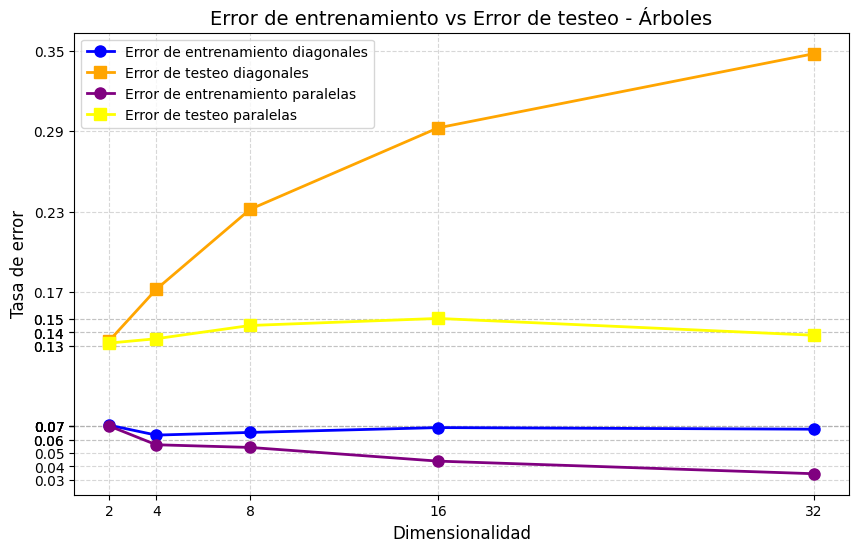

In [28]:
plotErrors(treeErrorsDiagonales[0],treeErrorsDiagonales[1],treeErrorsParalelas[0], treeErrorsParalelas[1], dims, "Error de entrenamiento vs Error de testeo - Árboles")

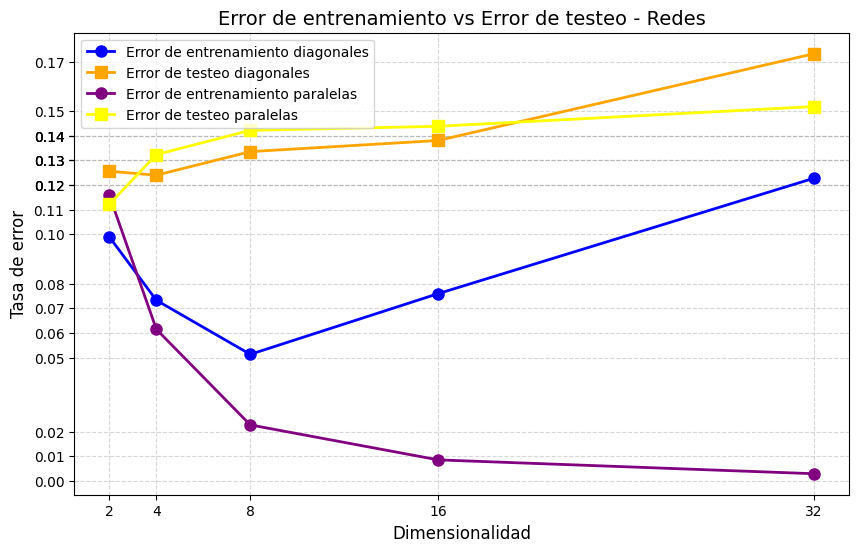

In [29]:
plotErrors(netErrorsDiagonales[0],netErrorsDiagonales[1],netErrorsParalelas[0], netErrorsParalelas[1], dims, "Error de entrenamiento vs Error de testeo - Redes")

### Comentarios sobre los resultados
El gráfico de errores correspondientes a los árboles ya fue analizado en el trabajo práctico anterior, por lo que ahora nos centraremos en comentar el nuevo gráfico generado para las redes neuronales.

Primero hablemos sobre el problema de las parelas. En este caso, el comportamiento observado en las redes neuronales es bastante similar al de los árboles de decisión. A medida que aumentamos la dimensionalidad del problema, los errores de testeo se mantienen relativamente constantes. La principal diferencia radica en el error de entrenamiento, que en el caso de las redes comienza siendo algo más elevado, aunque también tiende a reducirse progresivamente con el aumento de la dimensionalidad, tal como ocurría con los árboles.

Ahora hablemos sobre el problema de las diagonales. Aquí es donde se presentan las diferencias más notables respecto a los árboles. En particular, el error de testeo muestra un comportamiento mucho más estable a medida que aumenta la dimensionalidad. A diferencia de los árboles, cuyo desempeño empeoraba abruptamente en este contexto, las redes neuronales no se ven tan afectadas por la complejidad geométrica del problema. Esto se debe a que las redes pueden representar hiperplanos inclinados que dividen correctamente las clases, mientras que los árboles deben aproximar estas divisiones mediante cortes paralelos a los ejes, generando límites en forma de "escalones". Es una situación similar a los problemas clásicos del AND y OR, donde las redes pueden ajustar rectas inclinadas, mientras que los árboles quedan limitados a segmentaciones más rígidas.

En cuanto al error de entrenamiento en el problema de las diagonales, notamos que comienza a aumentar a partir de la dimensión 8. No logramos encontrar una explicación clara para este comportamiento. Sin embargo, observamos que este aumento coincide con un incremento en el error de testeo, lo cual sugiere cierta coordinación entre ambas curvas. Una posible hipótesis podría ser un desbalance en la generación de los conjuntos de entrenamiento. No obstante, esta posibilidad se descarta parcialmente dado que realizamos 20 ejecuciones independientes para cada dimensión, cada una con conjuntos de entrenamiento distintos.

No llegamos a reentrenar múltiples veces la red y probar con muchos parámetros diferentes (debido al costo de entrenar esta red), así que no pudimos llegar a muchas conclusiones de porque surge éste aumento en el error de entrenamiento en el problema de las diagonales.

# Problema 6 - Multiclase
Busque en los datasets de sklearn los archivos del problema iris y entrene una red sobre ellos. Tome un tercio de los datos como test, y los dos tercios restantes para entrenar y validar. Ajusto los parámetros de la red de manera conveniente. Realice curvas de entrenamiento, validación y test.

## Resolución
Comencemos por cargar los datasets y generar las particiones,

In [95]:
from sklearn.datasets import load_iris

iris = load_iris()

# Nos quedamos con las primeras tres columnas para los inputs
X = iris.data

# Y definimos como target la ultima columna
y = iris.target  

# Realicemos los splits.
# Sabemos que el dataset contiene 150 filas asi que directamente dividimos en 50 y 100.
testSize  = 50
valSize   = 25
trainSize = 75
totalTrainSize = valSize + trainSize
assert(testSize + totalTrainSize == len(X))

# Separamos primero en test y train
XTrain, XTest, YTrain, YTest = skl.model_selection.train_test_split(X, y, test_size = testSize, random_state = 42)

# Y luego a train en train y val
XTrain, XValidation, YTrain, YValidation = skl.model_selection.train_test_split(XTrain, YTrain, test_size = valSize, random_state = 42)


Se trata de un problema con target continuo, por lo que utilizaremos regresión. Lo primero que notamos es que el dataset es muy pequeño, y al tener que seleccionar un conjunto de test del mismo conjunto de datos el problema se agrava aún mas. 


Lo que queremos evitar es que nuestro modelo se sobreajuste a la pequeña muestra sobre la que lo entrenaremos. Para eso, nuestra primer idea es aplicar regularización y además utilizar un número de neuronas bajo en la capa oculta, pues tener una menor cantidad de pesos por aprender previene el sobreajuste en alguna medida. De todas maneras, probaremos distintos valores de gamma para testear si realmente es relevante.

In [96]:
# El learningRate y momentum los setteamos a valores estándar que utilizamos en ejercicios anteriores
learningRate = 0.05
momentum = 0.3

# Variaremos el coeficiente para la regularización
gammas = [10 ** i for i in range(-5, 0)]

# Y la cantidad de neuronas en la capa oculta
hiddenNeuronCounts = [2, 4, 6, 12]

trainingEvals = 4000 # deberia ser 4000
epochsPerEval = 20

# Cada red se entrenara `trainingsCount` veces para luego tomar la media de los entrenamientos como punto de comparacion
trainingsCount = 5 # Debería ser mas alto, como por ejemplo 10

De manera similar al ejercicio 2, evaluaremos todas las combinaciones variando el valor de gamma y la cantidad de neuronas en la capa oculta. Creemos entonces todos los classifiers,

In [98]:
classifiers = []

# Para cada valor de momentum
for gamma in gammas:

    # Creamos una lista de clasificadores con ese momentum
    classifiersPerGamma = []

    # Y para cada valor de learning rate
    for hiddenNeuronCount in hiddenNeuronCounts:

        # Agregamos el clasificador con ese learning rate y momentum a la lista de clasificadores con momentum
        classifiersPerGamma.append(
            MLPClassifier(
                hidden_layer_sizes=(hiddenNeuronCount,),
                activation = 'logistic',
                solver = 'sgd',
                alpha = gamma,
                batch_size = 1,
                learning_rate = 'constant',
                learning_rate_init = learningRate,
                momentum = momentum,
                nesterovs_momentum = False,
                tol = 0.0,
                warm_start = True,
                max_iter = epochsPerEval
            )
        )

    classifiers.append(classifiersPerGamma)

Y ahora los entrenamos y recolectamos sus errores de manera análoga la ejercicio 2. Para ello, primero necesitamos redefinir netTrain, pues las implementaciones que utilizamos hasta ahora no se ajustan a este problema.

In [99]:
@ignore_warnings(category=ConvergenceWarning)
def netTrain6(net, evalsCount, X_train, y_train, X_val, y_val, X_test,  y_test):

    error_train = []
    error_val = []
    error_test = []
    best_val_error = 1.0
    best_net = net
    
    for eval in range(evalsCount):
        net.fit(X_train, y_train)
        
        # error de training
        y_pred_train = net.predict(X_train)
        error_train.append(zero_one_loss(y_train, y_pred_train))
        
        # error de validacion
        y_pred_val = net.predict(X_val)
        cur_val_error = zero_one_loss(y_val, y_pred_val)
        error_val.append(cur_val_error)

        # error de test
        y_pred_test = net.predict(X_test)
        error_test.append(zero_one_loss(y_test, y_pred_test))  
        
        if best_val_error > cur_val_error:
            best_val_error = cur_val_error
            best_net = deepcopy(net)
          
    return best_net, error_train, error_val, error_test

In [100]:
train_errors = []
val_errors   = []
test_errors  = []

for classifiersPerGamma in classifiers:

    train_errors_per_gamma = []
    val_errors_per_gamma   = []
    test_errors_per_gamma  = []
    
    for classifier in classifiersPerGamma:

        print("Comenzando nuevo entrenamiento, paciencia")

        train_errors_acum = []
        val_errors_acum = []
        test_errors_acum = []

        train_error_avg_list = []
        val_error_avg_list   = []
        test_error_avg_list  = []

        for train in range(trainingsCount):
            _, train_errors_per_eval, val_errors_per_eval, test_errors_per_eval = netTrain6(
                classifier, trainingEvals, XTrain, YTrain, XValidation, YValidation, XTest, YTest)
    
            train_errors_acum.append(train_errors_per_eval)
            val_errors_acum.append(val_errors_per_eval)    
            test_errors_acum.append(test_errors_per_eval)    

        for i in range(trainingEvals): # i.e. for i in range(300)

            train_error_sum = 0
            val_error_sum   = 0
            test_error_sum  = 0
            
            for trainNumber in range(trainingsCount):

                train_error_sum = train_error_sum + train_errors_acum[trainNumber][i] 
                val_error_sum   = val_error_sum   + val_errors_acum[trainNumber][i]
                test_error_sum  = test_error_sum  + test_errors_acum[trainNumber][i]

            train_error_avg_list.append(train_error_sum / trainingsCount)
            val_error_avg_list.append(val_error_sum / trainingsCount)
            test_error_avg_list.append(test_error_sum / trainingsCount)
            
        train_errors_per_gamma.append(train_error_avg_list)
        val_errors_per_gamma.append(val_error_avg_list)
        test_errors_per_gamma.append(test_error_avg_list)

    train_errors.append(train_errors_per_gamma)
    val_errors.append(val_errors_per_gamma)
    test_errors.append(test_errors_per_gamma)

Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia
Comenzando nuevo entrenamiento, paciencia


Visualicemos los resultados

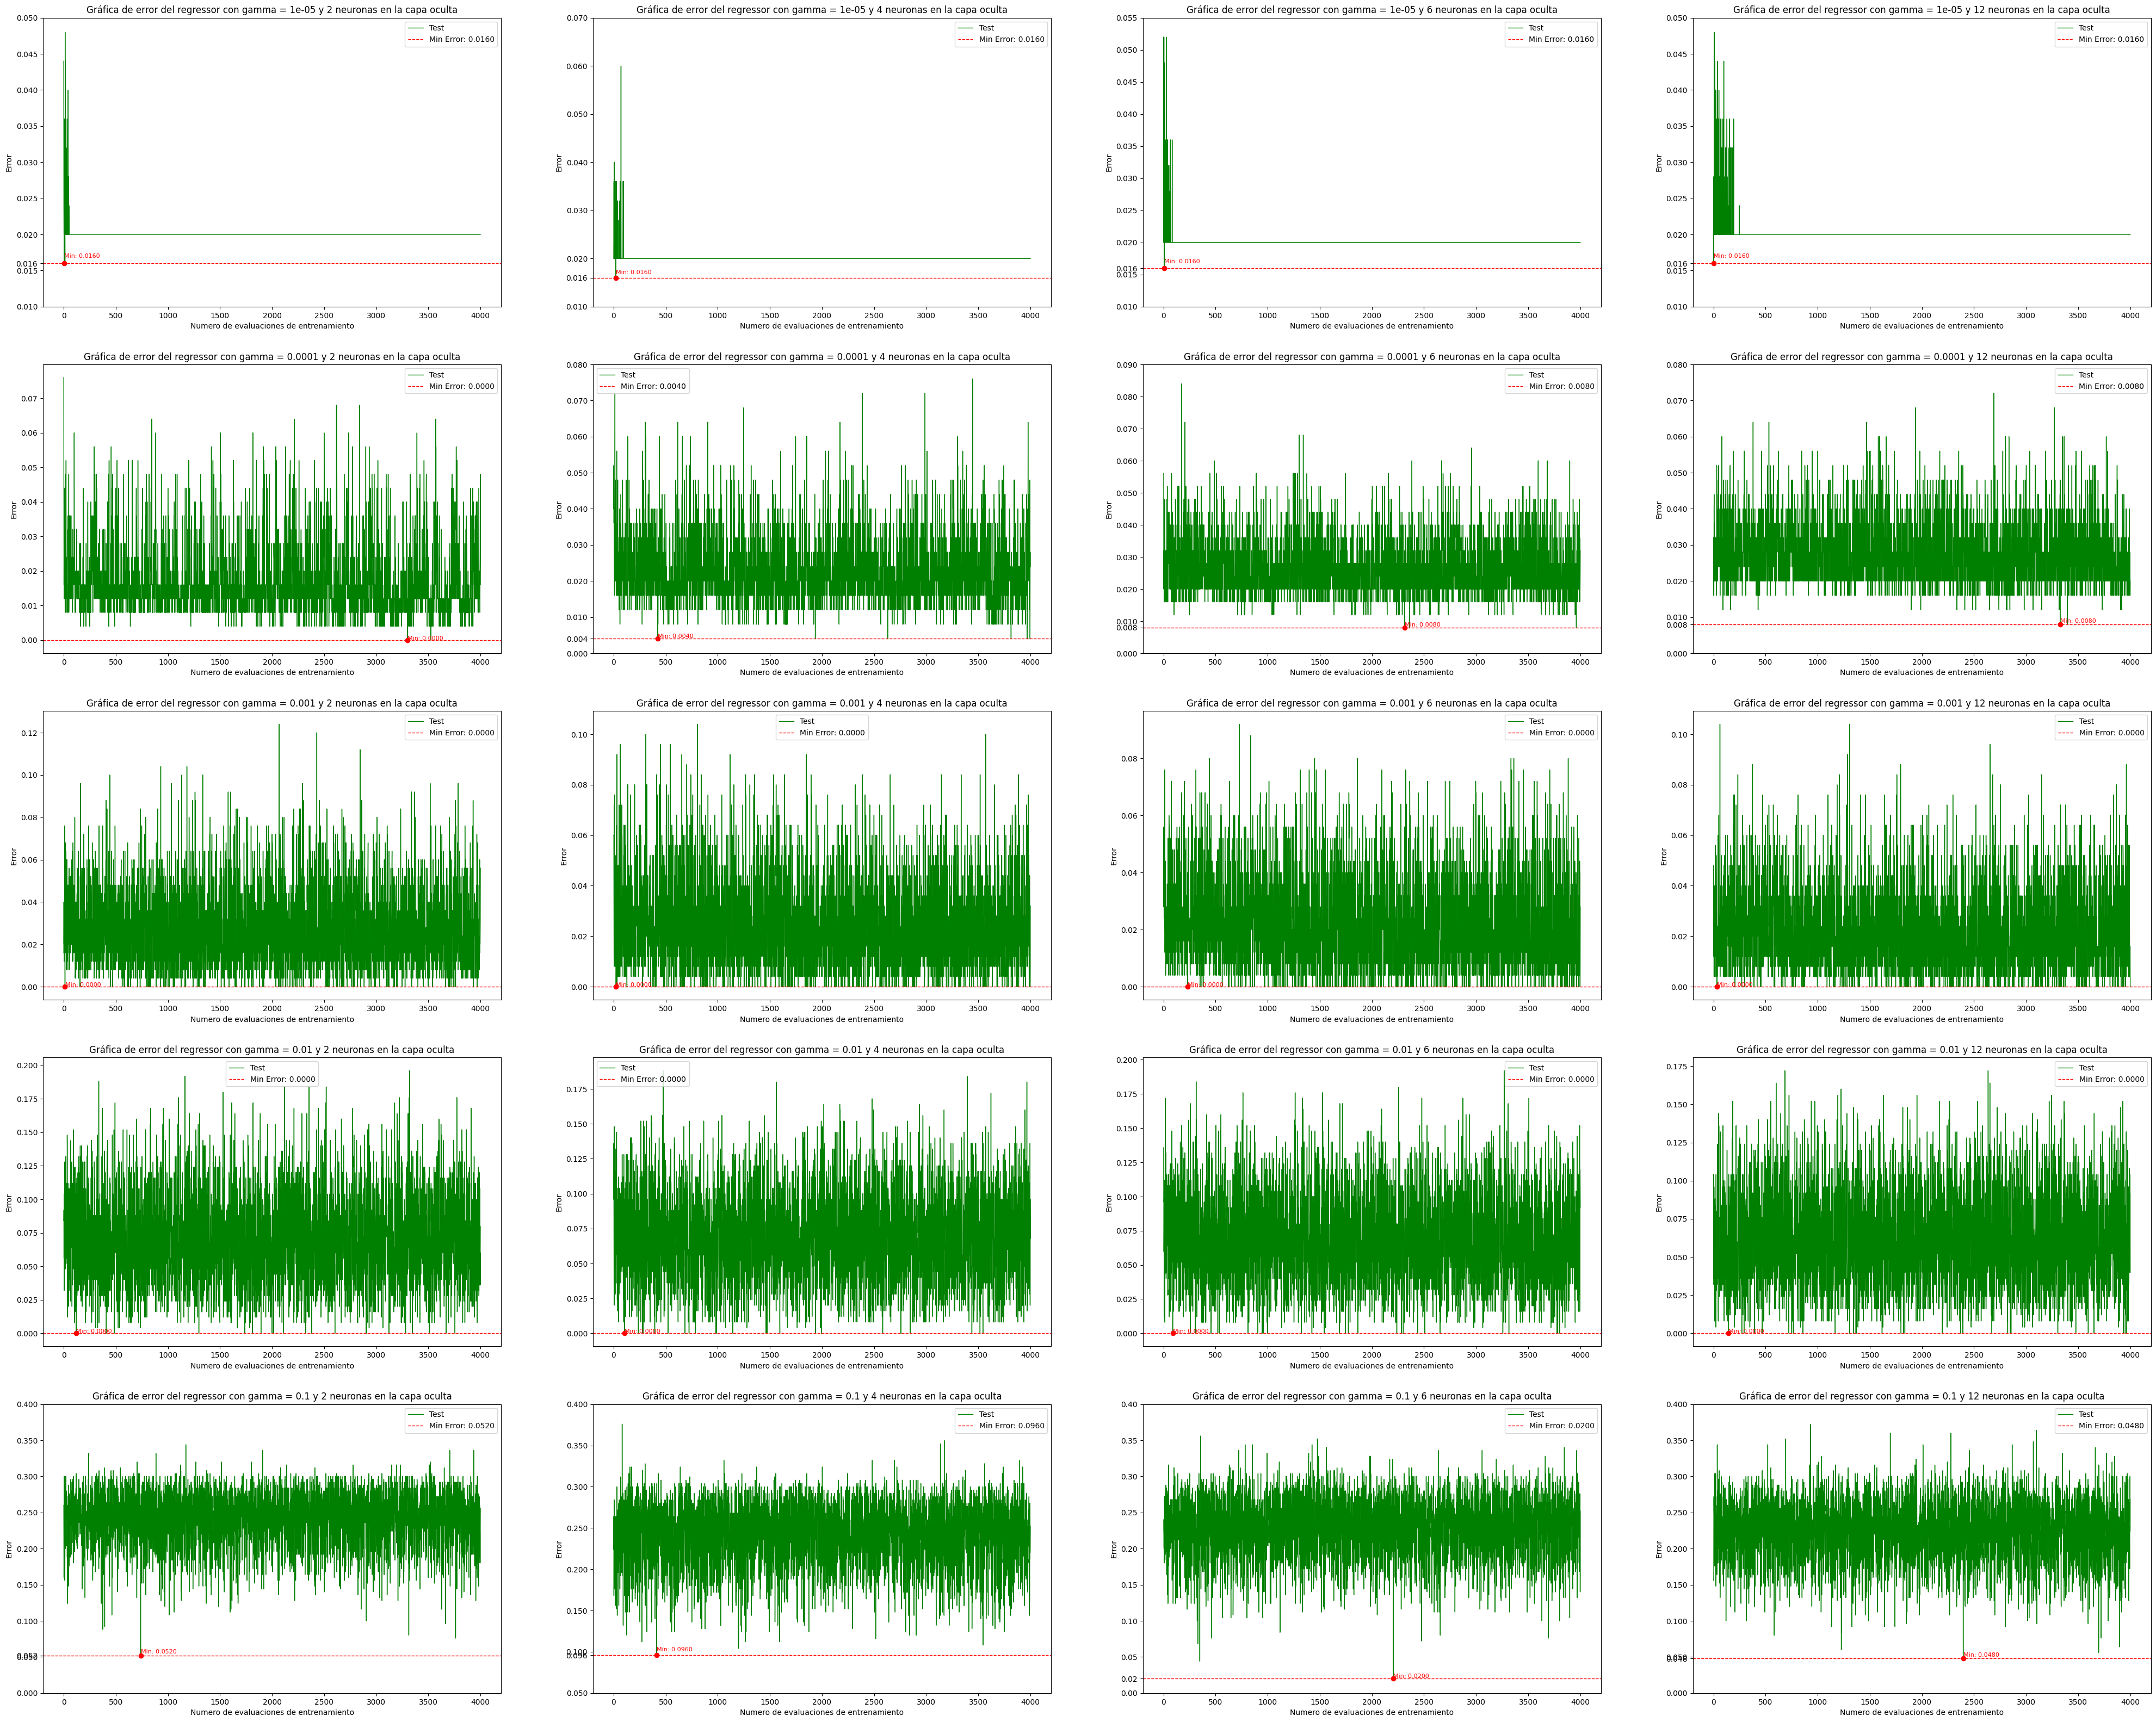

In [101]:
# Por cada valor de gamma mostramos en una misma fila sus tres valores de hiddenNeuronCount
fig, axes = plt.subplots(len(gammas), len(hiddenNeuronCounts), figsize = (50, 40))


# Para cada combinacion posible de momento y learningRate
for gm in range(len(gammas)):

    for hnc in range(len(hiddenNeuronCounts)):

        XValues = [i for i in range(1, trainingEvals + 1)]
        current_test_errors = test_errors[gm][hnc]
        
        # axes[gm][hnc].plot(XValues, train_errors[gm][hnc], color="blue",   linewidth=1, label='Train')
        # axes[gm][hnc].plot(XValues, val_errors[gm][hnc],   color="orange", linewidth=1, label='Validation')
        axes[gm][hnc].plot(XValues, test_errors[gm][hnc],  color="green",  linewidth=1, label='Test')

        # Nos interesa ver cual fue el minimo error también
        min_error = min(current_test_errors)
        min_pos = np.argmin(current_test_errors) + 1
        
        min_error = min(test_errors[gm][hnc])
        axes[gm][hnc].axhline(y=min_error, color='red', linestyle='--', linewidth=1, 
                             label=f'Min Error: {min_error:.4f}')
        axes[gm][hnc].plot(min_pos, min_error, 'ro')  # Le ponemos un punto rojo

        y_ticks = list(axes[gm][hnc].get_yticks())
        if min_error not in y_ticks:
            y_ticks.append(min_error)
            y_ticks.sort()
            axes[gm][hnc].set_yticks(y_ticks)
        
        axes[gm][hnc].text(min_pos + 0.5, min_error * 1.05, 
                          f'Min: {min_error:.4f}', color='red', fontsize=8)

        

        axes[gm][hnc].set(xlabel = 'Numero de evaluaciones de entrenamiento',
                      ylabel = 'Error',
                      title  = f"Gráfica de error del regressor con gamma = {gammas[gm]} y {hiddenNeuronCounts[hnc]} neuronas en la capa oculta")

        axes[gm][hnc].legend()

plt.savefig("ej6.png")

## Comentarios
En general, encontramos resultados bastante similares para casi todas las combinaciones de $\gamma$ y cantidad de neuronas en la capa oculta consideradas. Únicamente en el caso de $\gamma = 0.1$ se ve un aumento notorio en el error, que pasa del aproximadamente $3\%$ en todos los casos anteriores a un valor de entre $10\%$ y $14\%$ aproximadamente, dependiendo de la cantidad de neuronas. 

A la luz de los resultados, no fue tan relevante la cantidad de neuronas de la capa intermedia ni el valor de $\gamma$ escogido, pues cambios bastante significativos en sus valores nos generó resultados muy similares. Esto puede ser producto de que la regularización con el conjunto de validación ya era suficiente para prevenir el sobreajuste, por lo que el uso de otro mecanismo de regularización como el valor de $\gamma$ no sería particularmente util. Si ese fuera el caso, posiblemente hubiera sido mas interesante variar otro parámetro, como la tasa de aprendizaje o el momento, para intentar obtener un resultado distinto.

# Problema 6 - Multiclase - Faces
Baje el dataset Faces. Entrene una red neuronal para resolver dicho problema, eligiendo adecuadamente todos los parámetros (hay que re-escalar los datos al rango [0,1] antes de usarlos). Muestre curvas de entrenamiento para asegurar la convergencia. Compare los resultados con los citados en Mitchell (pag. 112). 

## Resolución
Comencemos por cargar los datos y dividirlos,

In [42]:
def load_face_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            row = [float(x) for x in line.strip().split(',') if x]
            data.append(row)
    data = np.array(data)
    X = data[:, :-1]  # Todas menos la ultima
    y = data[:, -1]   # La ultima
    return X / 255.0, y  # Y escalamos los inputs a [0, 1]

# Cargamos los conjuntos de entrenamiento y test
X_train, y_train = load_face_data('faces.data')
X_test, y_test = load_face_data('faces.test')

Proponemos valores que utilizamos en otros ejercicios como parámetros para el entrenamiento, y a modo de ejercicio variamos el tamaño de batch para observar si se produce un cambio en los distintos regresores.

In [87]:
learningRate = 0.05
momentum = 0.3

hiddenNeurons = 6

trainingEvals = 2000
epochsPerEval = 200

batchSizes = [1, 8, 16, 32]

Construyamos ahora los clasificadores,

In [88]:
classifiers = []

for batchSize in batchSizes:
    classifiers.append(MLPClassifier(
                        hidden_layer_sizes=(hiddenNeurons,),
                        activation='logistic',
                        solver='sgd',
                        batch_size=batchSize,
                        learning_rate='constant',
                        learning_rate_init=learningRate,
                        momentum=momentum,
                        nesterovs_momentum=False,
                        tol=0.0,
                        warm_start=True,
                        alpha = 0.001,  # Utilizamos un valor intermedio de alpha
                        max_iter=epochsPerEval))


Y definamos la función de entrenamiento que necesitamos, que es igual a la utilizada en el otro apartado del problema 6 pero sin el error de validación

In [89]:
@ignore_warnings(category=ConvergenceWarning)
def netTrain6(net, evalsCount, X_train, y_train, X_test,  y_test):

    error_train = []
    error_val = []
    error_test = []
    best_val_error = 1.0
    best_net = net
    
    for eval in range(evalsCount):
        net.fit(X_train, y_train)
        
        # error de training
        y_pred_train = net.predict(X_train)
        error_train.append(zero_one_loss(y_train, y_pred_train))

        # error de test
        y_pred_test = net.predict(X_test)
        error_test.append(zero_one_loss(y_test, y_pred_test))  

          
    return error_train, error_test

Ahora podemos entrenar todos los clasificadores,

In [90]:
trainErrors = []
testErrors = []
for classifier in classifiers:
    print("Entrenando")
    trainError, testError = netTrain6(classifier, trainingEvals, X_train, y_train, X_test, y_test)
    
    trainErrors.append(trainError)
    testErrors.append(testError)

Entrenando
Entrenando
Entrenando
Entrenando


Veamos las curvas de error,

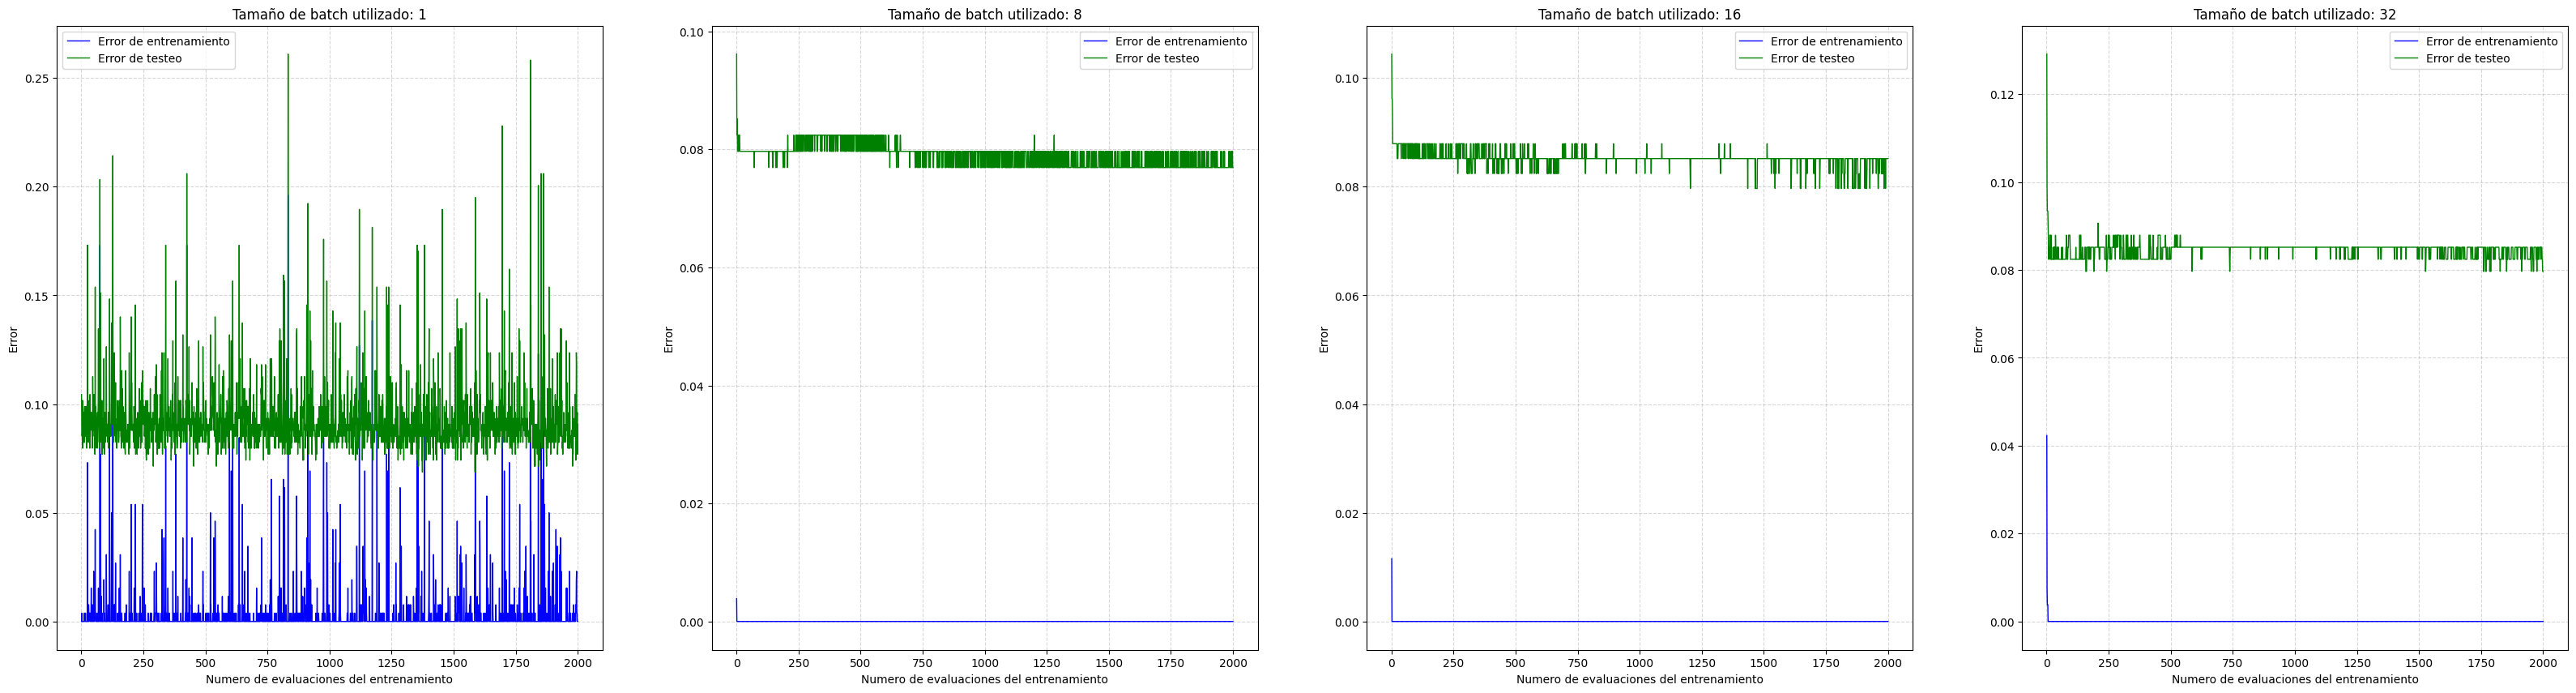

In [91]:
fig, axes = plt.subplots(1, len(batchSizes), figsize = (40, 10))

for i, batchSize in enumerate(batchSizes):

    XValues = [i for i in range(1,trainingEvals + 1)]
    
    axes[i].plot(XValues, trainErrors[i], color="blue", label = "Error de entrenamiento", linewidth = 1)
    axes[i].plot(XValues, testErrors[i], color="green", label = "Error de testeo", linewidth = 1)

    axes[i].set(xlabel = 'Numero de evaluaciones del entrenamiento', ylabel = 'Error', title = f'Tamaño de batch utilizado: {batchSize}')
    axes[i].legend()

     # Y setteamos los valores del eje Y para que matcheen con nuestros resultados
    axes[i].grid(True, which="both", linestyle='--', alpha=0.5)

## Comentarios

Lo primero que observamos en los gráficos es que las curvas de error para un tamaño de batch de 1 son completamente oscilantes, lo que tiene sentido al corresponderse con el descenso por el gradiente estocástico. Al utilizar tamaños mas grandes, las curvas se vuelven mucho mas constantes. En particular, las curvas de entrenamiento son prácticamente constantes en todos los casos, y las de error simplemente alternan entre algunos valores en cada época.

Comparando con los resultados de Mitchell, tenemos que para el tamaño de batch de 1 el error final gira en torno al 10%, que se corresponde con el valor de *accuracy* de 90% que menciona como resultado. Para valores mas altos de *batch size* encontramos resultados levemente mejores, mas cercanos al 8%. 

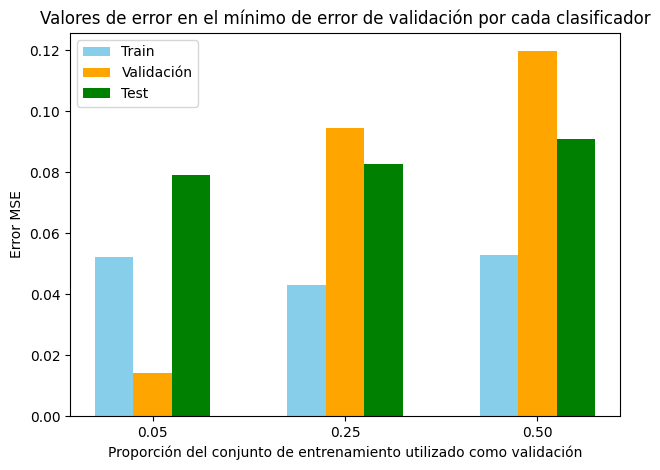

In [18]:
best_train_errors = []
best_val_errors = []
best_test_errors = []

# Para cada clasificador
for i in range(len(trainingInformation)):
    val_errors = trainingInformation[i][2]
    min_idx = val_errors.index(min(val_errors))  # Epoch con menor error de validación

    # Guardamos los errores correspondientes a ese epoch
    best_train_errors.append(trainingInformation[i][1][min_idx])
    best_val_errors.append(trainingInformation[i][2][min_idx])
    best_test_errors.append(trainingInformation[i][3][min_idx])

# Ahora graficamos los 3 sets de errores
regressors_names = [f'{validationProportions[i]:.2f}' for i in range(len(trainingInformation))]
error_types = ['Train', 'Validación', 'Test']
colors = ['blue', 'orange', 'green']
bar_width = 0.2
x = np.arange(len(regressors_names))

fig, ax = plt.subplots()

ax.bar(x - bar_width, best_train_errors, width=bar_width, label='Train', color=colors[0])
ax.bar(x, best_val_errors, width=bar_width, label='Validación', color=colors[1])
ax.bar(x + bar_width, best_test_errors, width=bar_width, label='Test', color=colors[2])

# Estética
ax.set_xlabel('Proporción del conjunto de entrenamiento utilizado como validación')
ax.set_ylabel('Error MSE')
ax.set_title('Valores de error en el mínimo de error de validación por cada clasificador')
ax.set_xticks(x)
ax.set_xticklabels(regressors_names)
ax.legend()

plt.tight_layout()
plt.show()

# Problema 7 - Minibatch
La implementación de sklearn permite usar minibatchs cambiando el parámetro batch_size. Realice una comparación de las curvas de aprendizaje para el problema de Sunspots, utilizando batches de longitud 1 y otros dos valores (3 curvas). Comente los resultados. Parametros del entrenamiento: 20% de validación, learning rate 0.05, momentum 0.3, 2000 evaluaciones del entrenamiento, cada una de 200 épocas, 6 neuronas en la capa intermedia. Los valores del minibatch se deben elegir para que en cada etapa de entrenamiento haya varias actualizaciones del gradiente, o sea que no debería ser mayor a 40.

In [131]:
learningRate = 0.05
momentum = 0.3

hiddenNeurons = 6

trainingEvals = 2000
epochsPerEval = 200

validationProportion = 0.20

# Elegimos estos valores para poder mostrar tamaños separados y lo más variados posibles en el rango [1,40]
batchSizes = [1, 10, 30]

In [132]:
sunSpotsData = dataFrameFromFile('ssp.data', tabulation=False)
sunSpotsTest = dataFrameFromFile('ssp.test', tabulation=False)

sunSpotsTrain, sunSpotsValidation = skl.model_selection.train_test_split(sunSpotsData, test_size = validationProportion, random_state = 42)

In [133]:
# Creamos los regresores con diferentes tamaños de batch
netRegressors = []

for batchSize in batchSizes:
    netRegressors.append(MLPRegressor(hidden_layer_sizes=(hiddenNeurons,), activation='logistic', solver='sgd', alpha=0.0, batch_size=batchSize,
                        learning_rate='constant', learning_rate_init=learningRate, momentum=momentum,nesterovs_momentum=False,
                        tol=0.0, warm_start=True, max_iter=epochsPerEval))

# Entrenamos los regresores a lo largo de las epocas y nos quedamos con el historico de errores de cada uno
trainErrors = []
validationErrors = []
testErrors = []
for regressor in netRegressors:
    _, trainError, valError, testError = netTrain(regressor, trainingEvals, sunSpotsTrain, sunSpotsValidation, mean_squared_error, testSet = sunSpotsTest)
    trainErrors.append(trainError)
    validationErrors.append(valError)
    testErrors.append(testError)

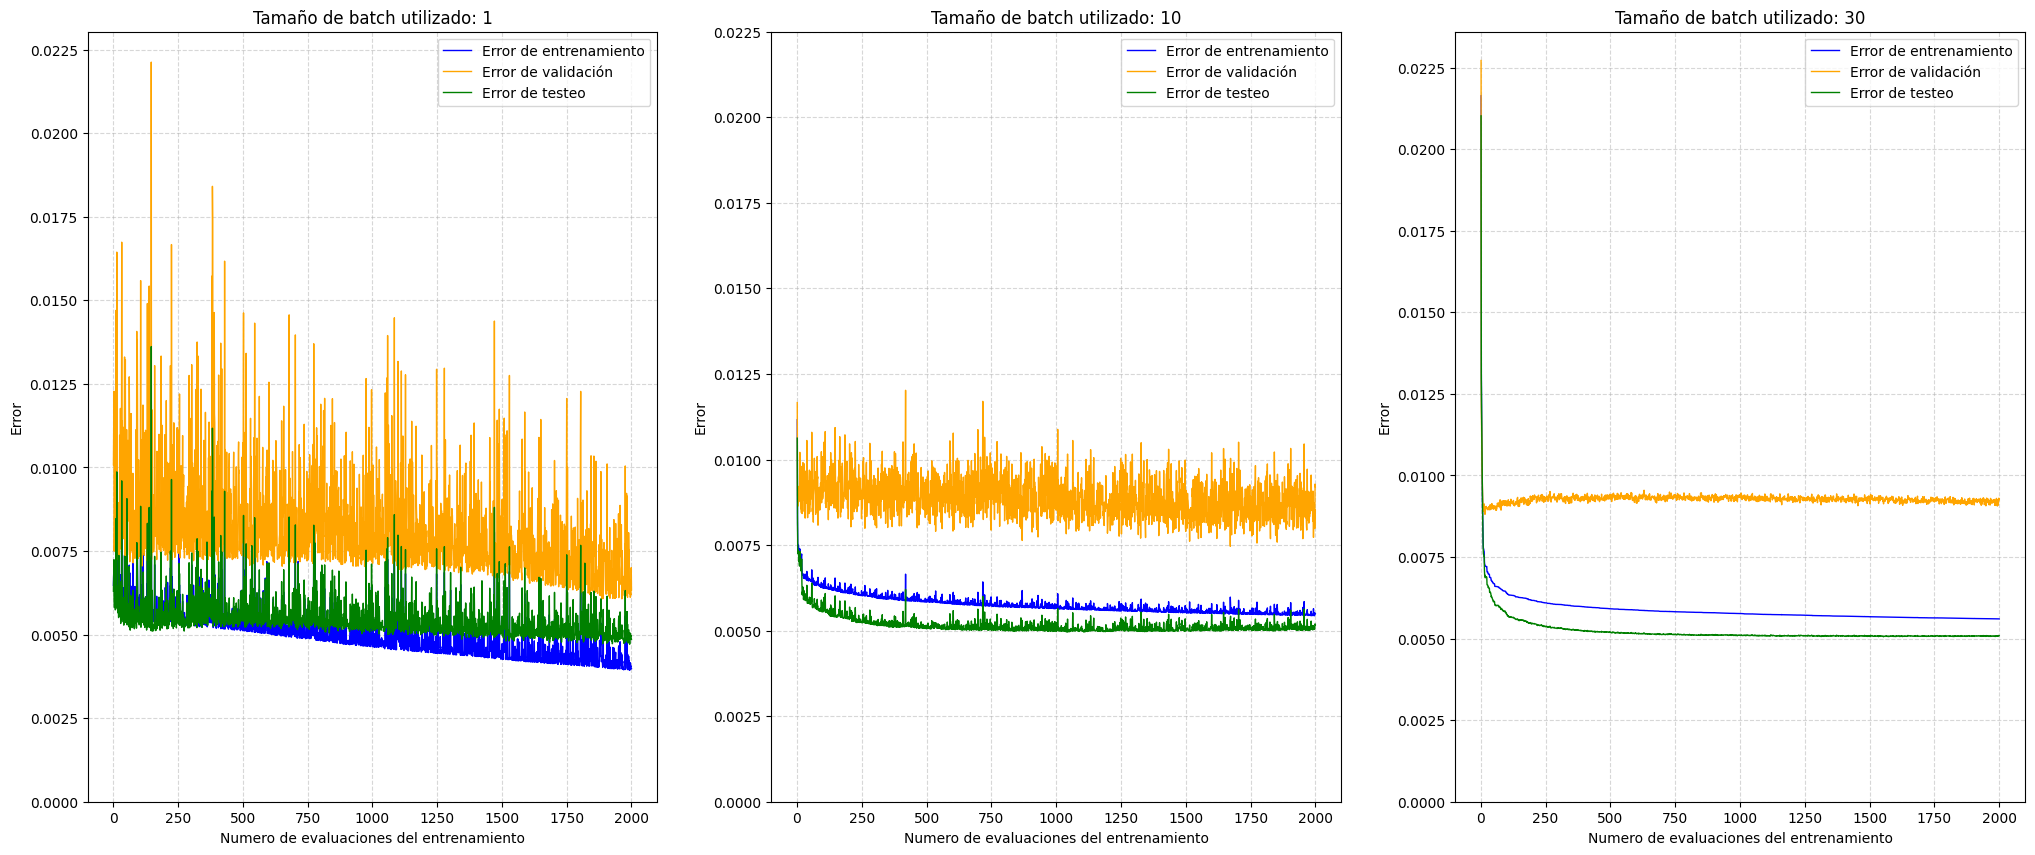

In [134]:
fig, axes = plt.subplots(1, len(batchSizes), figsize = (25, 10))

for i, batchSize in enumerate(batchSizes):

    XValues = [i for i in range(1,trainingEvals + 1)]
    
    axes[i].plot(XValues, trainErrors[i], color="blue", label = "Error de entrenamiento", linewidth = 1)
    axes[i].plot(XValues, validationErrors[i], color="orange", label = "Error de validación", linewidth = 1)
    axes[i].plot(XValues, testErrors[i], color="green", label = "Error de testeo", linewidth = 1)

    axes[i].set(xlabel = 'Numero de evaluaciones del entrenamiento', ylabel = 'Error', title = f'Tamaño de batch utilizado: {batchSize}')
    axes[i].legend()

     # Y setteamos los valores del eje Y para que matcheen con nuestros resultados
    axes[i].set_yticks(np.arange(0,0.025, 0.0025))
    axes[i].grid(True, which="both", linestyle='--', alpha=0.5)
    

### Comentarios sobre los resultados
Como vimos en la teoría, existen tres formas principales de elegir el tamaño del batch durante el entrenamiento: batch completo, estocástico y mini-batch. Cada una de estas opciones representa una manera distinta de actualizar el gradiente a medida que se recorre el conjunto de entrenamiento.

A medida que aumentamos el tamaño del batch, nos aproximamos con mayor precisión al gradiente real de la función que intentamos minimizar, lo que genera un camino más directo hacia un mínimo. Sin embargo, esto tiene un inconveniente: al seguir una trayectoria tan precisa, corremos el riesgo de quedar atrapados en un mínimo local, sin posibilidad de salir. Por el contrario, al usar batches más pequeños, evitamos seguir de manera tan estricta al gradiente real, lo que introduce cierta aleatoriedad y permite explorar más ampliamente el espacio de soluciones.

Lo más relevante que se puede observar es que, aunque las gráficas varíen considerablemente en cuanto a los “picos” o fluctuaciones, todos los errores tienden a estabilizarse de manera similar.

Estos picos se deben principalmente a las diferencias en el tamaño del batch: con batches pequeños, el camino hacia el mínimo es más irregular, lo que puede provocar aumentos temporales del error debido a una mayor variabilidad en las actualizaciones. En cambio, con batches más grandes, la trayectoria es más suave y estable, ya que seguimos con mayor precisión la dirección del gradiente. Aunque un mini-batch de tamaño 30 no sea un batch completo, al ser relativamente grande en relación al conjunto total de datos, puede considerarse como una buena aproximación.

El hecho de que todos los errores se estabilicen alrededor de valores similares puede explicarse por la estabilidad de la función objetivo en la región donde se realiza el descenso del gradiente. En otras palabras, ya sea que la búsqueda sea más aleatoria o más dirigida, el proceso termina conduciendo hacia una solución cercana al mínimo.

Finalmente, se puede observar que alrededor de las 300 evaluaciones, el clasificador que utiliza un batch estocástico alcanza un error de entrenamiento cercano a 0.005. Esto podría atribuirse a que las actualizaciones estocásticas permiten al modelo escapar de un mínimo local y alcanzar configuraciones de pesos que producen un menor error. No obstante, la diferencia es mínima, por lo que se puede concluir que los tres métodos alcanzan resultados finales muy similares.